Funding Rate Direction Prediction using Machine Learning
This script predicts whether the next funding rate will be positive or negative

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from pathlib import Path
BASE_PATH = Path.cwd()
FEATURE_COLS = [
    # Basis features (most important for funding rate prediction)
    'basis', 'basis_30m_avg', 'basis_1h_avg', 'basis_4h_avg',
    'basis_change_30m', 'basis_change_1h',
    'basis_min_30m', 'basis_min_1h',
    'basis_std_30m', 'basis_std_1h', 'basis_std_24h',
    'basis_zscore_30m', 'basis_zscore_1h', 'basis_zscore_24h',

    # Taker imbalance (futures)
    'taker_buy_ratio', 'futures_taker_buy_30m_avg', 'futures_taker_buy_1h_avg',
    'futures_taker_zscore',

    # Taker imbalance (spot)
    'spot_taker_buy_ratio',

    # Futures vs Spot taker difference
    'taker_futures_spot_diff',

    # Price momentum
    'ret_30m', 'ret_1h', 'ret_4h', 'ret_24h',
    'volatility_30m', 'volatility_1h', 'volatility_4h',

    # Volume
    'volume_zscore_30m', 'volume_zscore_1h', 'volume_zscore_4h', 'volume_zscore_24h',
    'trade_count_zscore_30m', 'trade_count_zscore_1h', 'trade_count_zscore_4h', 'trade_count_zscore_24h',

    # Funding rate history (CRITICAL - but only past values!)
    'prev_fr', 'prev_fr_avg_3', 'consecutive_neg',

    # Time features
    'hour_of_day', 'day_of_week'
]

In [5]:
# EDA VISUALIZATION FUNCTIONS
# ============================================================

def plot_feature_categories(save_path=None):
    """Plot feature categories as a professional horizontal bar chart.

    Args:
        save_path: Optional path to save the figure
    """
    # Feature categories and counts
    categories = {
        'Basis Features': 14,
        'Taker Imbalance': 6,
        'Price Momentum': 7,
        'Volume Features': 8,
        'Funding Rate History': 3,
        'Time Features': 2
    }

    names = list(categories.keys())
    counts = list(categories.values())
    total = sum(counts)

    # Professional color palette
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728', '#9467bd', '#17becf']

    # Create figure with professional styling
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create horizontal bar chart
    bars = ax.barh(names, counts, color=colors, edgecolor='white', linewidth=0.7, height=0.6)

    # Add count labels on bars
    for bar, count in zip(bars, counts):
        ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
                f'{count}', va='center', ha='left', fontsize=11, fontweight='bold', color='#333333')

    # Styling
    ax.set_xlabel('Number of Features', fontsize=12, fontweight='bold', color='#333333')
    ax.set_title(f'Feature Engineering: {total} Features Across 6 Categories',
                 fontsize=14, fontweight='bold', color='#333333', pad=15)
    ax.invert_yaxis()
    ax.set_xlim(0, max(counts) + 3)

    # Professional grid and spines
    ax.grid(axis='x', alpha=0.3, linestyle='--', color='#cccccc')
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')

    # Tick styling
    ax.tick_params(axis='both', colors='#333333', labelsize=11)
    ax.set_yticklabels(names, fontweight='medium')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to {save_path}")

    plt.show()

    return fig


def plot_model_prediction_metrics(model_name='LightGBM', base_path=BASE_PATH, save_path=None):
    """Plot prediction accuracy metrics (Precision, Recall, F1, AUC) by symbol for a specific model.

    Args:
        model_name: Name of the model to filter (e.g., 'LightGBM', 'XGBoost', 'RandomForest')
        base_path: Base path where results folder is located
        save_path: Optional path to save the figure
    """
    # Load results CSV
    results_path = base_path / 'results' / 'backtest_comparison_summary.csv'
    if not results_path.exists():
        print(f"Results file not found: {results_path}")
        return None

    df_results = pd.read_csv(results_path)

    # Filter by model name
    df_model = df_results[df_results['model'] == model_name].copy()

    if len(df_model) == 0:
        print(f"No results found for model: {model_name}")
        print(f"Available models: {df_results['model'].unique().tolist()}")
        return None

    # Get latest result per symbol (in case of duplicates)
    df_model = df_model.sort_values('timestamp').groupby('symbol').last().reset_index()

    # Sort by F1 score descending
    df_model = df_model.sort_values('test_f1', ascending=True)

    symbols = df_model['symbol'].values
    n_symbols = len(symbols)

    # Metrics to plot (including Accuracy)
    metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
    # Professional color palette - muted tones (Accuracy in orange for distinction)
    colors = ['#E67E22', '#1B4F72', '#2874A6', '#148F77', '#7D3C98']

    # Create figure
    fig, ax = plt.subplots(figsize=(12, max(6, n_symbols * 0.5)))

    # Bar positions
    y_pos = np.arange(n_symbols)
    bar_height = 0.15  # Slightly smaller for 5 metrics

    # Plot each metric as grouped horizontal bars
    for i, (metric, label, color) in enumerate(zip(metrics, metric_labels, colors)):
        values = df_model[metric].values
        offset = (i - 2) * bar_height  # Adjusted for 5 metrics: -2, -1, 0, 1, 2
        bars = ax.barh(y_pos + offset, values, bar_height, label=label, color=color, alpha=0.8, edgecolor='white')

        # Add value labels
        for bar, val in zip(bars, values):
            ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.2f}',
                   va='center', ha='left', fontsize=8, color='#333333')

    # Styling
    ax.set_yticks(y_pos)
    ax.set_yticklabels(symbols, fontsize=10)
    ax.set_xlabel('Score', fontsize=12, fontweight='bold')
    ax.set_title(f'{model_name} - Prediction Metrics by Symbol', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlim(0, 1.15)
    ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Baseline (0.5)')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(axis='x', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to {save_path}")

    plt.show()

    return fig, df_model


def plot_model_backtest_returns(model_name='LightGBM', base_path=BASE_PATH, save_path=None):
    """Plot backtest returns (Total PnL, Avg PnL, Win Rate) by symbol for a specific model.

    Args:
        model_name: Name of the model to filter (e.g., 'LightGBM', 'XGBoost', 'RandomForest')
        base_path: Base path where results folder is located
        save_path: Optional path to save the figure
    """
    # Load results CSV
    results_path = base_path / 'results' / 'backtest_comparison_summary.csv'
    if not results_path.exists():
        print(f"Results file not found: {results_path}")
        return None

    df_results = pd.read_csv(results_path)

    # Filter by model name
    df_model = df_results[df_results['model'] == model_name].copy()

    if len(df_model) == 0:
        print(f"No results found for model: {model_name}")
        print(f"Available models: {df_results['model'].unique().tolist()}")
        return None

    # Get latest result per symbol (in case of duplicates)
    df_model = df_model.sort_values('timestamp').groupby('symbol').last().reset_index()

    # Sort by total PnL descending
    df_model = df_model.sort_values('total_pnl_pct', ascending=True)

    symbols = df_model['symbol'].values
    n_symbols = len(symbols)

    # Create figure with 3 subplots - wider for better readability
    fig, axes = plt.subplots(1, 3, figsize=(22, max(6, n_symbols * 0.5)))

    # Professional color palette
    color_positive = '#1D5B79'  # Deep teal for positive
    color_negative = '#A94438'  # Muted red for negative
    color_above_baseline = '#1D5B79'  # Deep teal for above 50%
    color_below_baseline = '#C27B41'  # Muted orange for below 50%

    # Plot 1: Total PnL %
    ax1 = axes[0]
    colors1 = [color_positive if x >= 0 else color_negative for x in df_model['total_pnl_pct']]
    bars1 = ax1.barh(symbols, df_model['total_pnl_pct'], color=colors1, alpha=0.85, edgecolor='white', linewidth=0.5)
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax1.set_xlabel('Total PnL (%)', fontsize=11, fontweight='bold')
    ax1.set_title('Total PnL by Symbol', fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    # Add value labels
    for bar, val in zip(bars1, df_model['total_pnl_pct']):
        x_pos = val + 0.5 if val >= 0 else val - 0.5
        ha = 'left' if val >= 0 else 'right'
        ax1.text(x_pos, bar.get_y() + bar.get_height()/2, f'{val:.2f}%',
                va='center', ha=ha, fontsize=9, fontweight='bold')

    # Plot 2: Avg PnL per Trade %
    ax2 = axes[1]
    colors2 = [color_positive if x >= 0 else color_negative for x in df_model['avg_pnl_pct']]
    bars2 = ax2.barh(symbols, df_model['avg_pnl_pct'], color=colors2, alpha=0.85, edgecolor='white', linewidth=0.5)
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('Avg PnL per Trade (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Avg PnL per Trade', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_yticklabels([])  # Hide y-labels for middle plot
    for bar, val in zip(bars2, df_model['avg_pnl_pct']):
        x_pos = val + 0.02 if val >= 0 else val - 0.02
        ha = 'left' if val >= 0 else 'right'
        ax2.text(x_pos, bar.get_y() + bar.get_height()/2, f'{val:.3f}%',
                va='center', ha=ha, fontsize=9, fontweight='bold')

    # Plot 3: Win Rate %
    ax3 = axes[2]
    win_rates = df_model['win_rate'] * 100  # Convert to percentage
    colors3 = [color_above_baseline if x >= 50 else color_below_baseline for x in win_rates]
    bars3 = ax3.barh(symbols, win_rates, color=colors3, alpha=0.85, edgecolor='white', linewidth=0.5)
    ax3.axvline(x=50, color='gray', linestyle='--', linewidth=1.5, label='50% Baseline')
    ax3.set_xlabel('Win Rate (%)', fontsize=11, fontweight='bold')
    ax3.set_title('Win Rate by Symbol', fontsize=12, fontweight='bold')
    ax3.set_xlim(0, 100)
    ax3.grid(axis='x', alpha=0.3)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.set_yticklabels([])  # Hide y-labels for right plot
    ax3.legend(loc='lower right', fontsize=9)
    for bar, val in zip(bars3, win_rates):
        ax3.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f}%',
                va='center', ha='left', fontsize=9, fontweight='bold')

    # Overall title
    fig.suptitle(f'{model_name} - Backtest Performance Summary', fontsize=14, fontweight='bold', y=1.02)
    fig.patch.set_facecolor('white')
    for ax in axes:
        ax.set_facecolor('white')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to {save_path}")

    plt.show()

    # Print summary statistics
    print(f"\n{'='*60}")
    print(f"{model_name} BACKTEST SUMMARY")
    print('='*60)
    print(f"Total Symbols: {n_symbols}")
    print(f"Avg Total PnL: {df_model['total_pnl_pct'].mean():.4f}%")
    print(f"Avg Win Rate: {df_model['win_rate'].mean()*100:.2f}%")
    print(f"Best Symbol: {df_model.iloc[-1]['symbol']} ({df_model.iloc[-1]['total_pnl_pct']:.2f}% PnL)")
    print(f"Worst Symbol: {df_model.iloc[0]['symbol']} ({df_model.iloc[0]['total_pnl_pct']:.2f}% PnL)")

    return fig, df_model


# ============================================================
# ML MODEL COMPARISON FUNCTIONS (ALL MODELS)
# ============================================================

def compare_all_models_metrics(base_path=BASE_PATH, save_path=None):
    """Compare prediction metrics across all ML models with grouped bar chart.

    Returns:
        fig: matplotlib figure
        df_summary: DataFrame with aggregated metrics per model
    """
    results_path = base_path / 'results' / 'backtest_comparison_summary.csv'
    if not results_path.exists():
        print(f"Results file not found: {results_path}")
        return None, None

    df_results = pd.read_csv(results_path)

    # Get latest result per symbol-model combination
    df_latest = df_results.sort_values('timestamp').groupby(['symbol', 'model']).last().reset_index()

    # Calculate mean metrics per model across all symbols
    metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

    df_summary = df_latest.groupby('model')[metrics].mean().reset_index()
    df_summary = df_summary.sort_values('test_f1', ascending=False)

    models = df_summary['model'].values
    n_models = len(models)

    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8))

    # Bar positions
    x = np.arange(n_models)
    width = 0.15
    colors = ['#E67E22', '#1B4F72', '#2874A6', '#148F77', '#7D3C98']

    # Plot each metric
    for i, (metric, label, color) in enumerate(zip(metrics, metric_labels, colors)):
        values = df_summary[metric].values
        offset = (i - 2) * width
        bars = ax.bar(x + offset, values, width, label=label, color=color, alpha=0.85, edgecolor='white')

        # Add value labels on top
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.2f}',
                   ha='center', va='bottom', fontsize=7, rotation=45)

    # Styling
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('ML Model Comparison - Prediction Metrics (Averaged Across All Tickers)',
                fontsize=14, fontweight='bold', pad=15)
    ax.set_ylim(0, 1.15)
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Baseline (0.5)')
    ax.legend(loc='upper right', fontsize=9, ncol=2)
    ax.grid(axis='y', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to {save_path}")

    plt.show()

    # Print ranking
    print(f"\n{'='*60}")
    print("MODEL RANKING BY F1 SCORE")
    print('='*60)
    for i, row in df_summary.iterrows():
        print(f"{row['model']:20s} | F1: {row['test_f1']:.4f} | ROC-AUC: {row['test_roc_auc']:.4f}")

    return fig, df_summary


def compare_all_models_returns(base_path=BASE_PATH, save_path=None):
    """Compare backtest returns across all ML models.

    Returns:
        fig: matplotlib figure
        df_summary: DataFrame with aggregated returns per model
    """
    results_path = base_path / 'results' / 'backtest_comparison_summary.csv'
    if not results_path.exists():
        print(f"Results file not found: {results_path}")
        return None, None

    df_results = pd.read_csv(results_path)

    # Get latest result per symbol-model combination
    df_latest = df_results.sort_values('timestamp').groupby(['symbol', 'model']).last().reset_index()

    # Calculate aggregated returns per model (SUM of total_pnl across all tickers)
    df_summary = df_latest.groupby('model').agg({
        'total_pnl_pct': 'sum',  # Total PnL aggregated across all tickers
        'avg_pnl_pct': 'mean',   # Average of avg PnL per trade
        'win_rate': 'mean',      # Average win rate
        'n_trades': 'sum'        # Total trades across all tickers
    }).reset_index()

    df_summary = df_summary.sort_values('total_pnl_pct', ascending=True)

    models = df_summary['model'].values
    n_models = len(models)

    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))

    color_positive = '#1D5B79'
    color_negative = '#A94438'
    color_above_baseline = '#1D5B79'
    color_below_baseline = '#C27B41'

    # Plot 1: Total PnL % (Aggregated)
    ax1 = axes[0]
    colors1 = [color_positive if x >= 0 else color_negative for x in df_summary['total_pnl_pct']]
    bars1 = ax1.barh(models, df_summary['total_pnl_pct'], color=colors1, alpha=0.85, edgecolor='white')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax1.set_xlabel('Total PnL (%) - All Tickers Combined', fontsize=11, fontweight='bold')
    ax1.set_title('Aggregated Total PnL', fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    for bar, val in zip(bars1, df_summary['total_pnl_pct']):
        x_pos = val + 2 if val >= 0 else val - 2
        ha = 'left' if val >= 0 else 'right'
        ax1.text(x_pos, bar.get_y() + bar.get_height()/2, f'{val:.1f}%',
                va='center', ha=ha, fontsize=10, fontweight='bold')

    # Plot 2: Avg PnL per Trade %
    ax2 = axes[1]
    colors2 = [color_positive if x >= 0 else color_negative for x in df_summary['avg_pnl_pct']]
    bars2 = ax2.barh(models, df_summary['avg_pnl_pct'], color=colors2, alpha=0.85, edgecolor='white')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('Avg PnL per Trade (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Avg PnL per Trade (Mean Across Tickers)', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_yticklabels([])
    for bar, val in zip(bars2, df_summary['avg_pnl_pct']):
        x_pos = val + 0.02 if val >= 0 else val - 0.02
        ha = 'left' if val >= 0 else 'right'
        ax2.text(x_pos, bar.get_y() + bar.get_height()/2, f'{val:.3f}%',
                va='center', ha=ha, fontsize=10, fontweight='bold')

    # Plot 3: Win Rate %
    ax3 = axes[2]
    win_rates = df_summary['win_rate'] * 100
    colors3 = [color_above_baseline if x >= 50 else color_below_baseline for x in win_rates]
    bars3 = ax3.barh(models, win_rates, color=colors3, alpha=0.85, edgecolor='white')
    ax3.axvline(x=50, color='gray', linestyle='--', linewidth=1.5, label='50% Baseline')
    ax3.set_xlabel('Win Rate (%)', fontsize=11, fontweight='bold')
    ax3.set_title('Avg Win Rate Across Tickers', fontsize=12, fontweight='bold')
    ax3.set_xlim(0, 100)
    ax3.grid(axis='x', alpha=0.3)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.set_yticklabels([])
    ax3.legend(loc='lower right', fontsize=9)
    for bar, val in zip(bars3, win_rates):
        ax3.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f}%',
                va='center', ha='left', fontsize=10, fontweight='bold')

    fig.suptitle('ML Model Comparison - Backtest Performance (Aggregated Across All Tickers)',
                fontsize=14, fontweight='bold', y=1.02)
    fig.patch.set_facecolor('white')
    for ax in axes:
        ax.set_facecolor('white')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to {save_path}")

    plt.show()

    # Print summary
    print(f"\n{'='*70}")
    print("MODEL RANKING BY AGGREGATED TOTAL PnL")
    print('='*70)
    df_sorted = df_summary.sort_values('total_pnl_pct', ascending=False)
    for _, row in df_sorted.iterrows():
        print(f"{row['model']:20s} | Total PnL: {row['total_pnl_pct']:8.2f}% | "
              f"Trades: {int(row['n_trades']):5d} | Win Rate: {row['win_rate']*100:5.1f}%")

    return fig, df_summary


def compare_all_models_heatmap(base_path=BASE_PATH, save_path=None):
    """Create a heatmap showing model performance across all tickers and metrics.

    Returns:
        fig: matplotlib figure
        df_pivot: DataFrame with pivoted data
    """
    import seaborn as sns

    results_path = base_path / 'results' / 'backtest_comparison_summary.csv'
    if not results_path.exists():
        print(f"Results file not found: {results_path}")
        return None, None

    df_results = pd.read_csv(results_path)
    df_latest = df_results.sort_values('timestamp').groupby(['symbol', 'model']).last().reset_index()

    # Create pivot tables for different metrics
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))

    # Heatmap 1: Total PnL by Model x Symbol
    ax1 = axes[0, 0]
    df_pivot1 = df_latest.pivot(index='model', columns='symbol', values='total_pnl_pct')
    sns.heatmap(df_pivot1, annot=True, fmt='.1f', cmap='RdYlGn', center=0, ax=ax1,
               cbar_kws={'label': 'Total PnL (%)'}, annot_kws={'size': 8})
    ax1.set_title('Total PnL (%) by Model x Ticker', fontsize=12, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('Model', fontsize=10)

    # Heatmap 2: F1 Score by Model x Symbol
    ax2 = axes[0, 1]
    df_pivot2 = df_latest.pivot(index='model', columns='symbol', values='test_f1')
    sns.heatmap(df_pivot2, annot=True, fmt='.2f', cmap='Blues', ax=ax2,
               cbar_kws={'label': 'F1 Score'}, annot_kws={'size': 8})
    ax2.set_title('F1 Score by Model x Ticker', fontsize=12, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('')

    # Heatmap 3: Win Rate by Model x Symbol
    ax3 = axes[1, 0]
    df_pivot3 = df_latest.pivot(index='model', columns='symbol', values='win_rate') * 100
    sns.heatmap(df_pivot3, annot=True, fmt='.1f', cmap='RdYlGn', center=50, ax=ax3,
               cbar_kws={'label': 'Win Rate (%)'}, annot_kws={'size': 8})
    ax3.set_title('Win Rate (%) by Model x Ticker', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Symbol', fontsize=10)
    ax3.set_ylabel('Model', fontsize=10)

    # Heatmap 4: ROC-AUC by Model x Symbol
    ax4 = axes[1, 1]
    df_pivot4 = df_latest.pivot(index='model', columns='symbol', values='test_roc_auc')
    sns.heatmap(df_pivot4, annot=True, fmt='.2f', cmap='Purples', ax=ax4,
               cbar_kws={'label': 'ROC-AUC'}, annot_kws={'size': 8})
    ax4.set_title('ROC-AUC by Model x Ticker', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Symbol', fontsize=10)
    ax4.set_ylabel('')

    fig.suptitle('ML Model Performance Heatmaps - All Tickers', fontsize=14, fontweight='bold', y=1.01)
    fig.patch.set_facecolor('white')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to {save_path}")

    plt.show()

    return fig, df_pivot1


def get_trade_date_range(base_path=BASE_PATH):
    """Get the start and end dates of trades for all models.

    Returns:
        dict: Dictionary with model names as keys and (start_date, end_date, n_trades) as values
    """
    results_path = base_path / 'results'
    trade_files = list(results_path.glob('*_trades.csv'))

    if not trade_files:
        print("No trade files found")
        return None

    date_ranges = {}
    all_trades = []

    for trade_file in trade_files:
        parts = trade_file.stem.split('_')
        if len(parts) >= 2:
            symbol = parts[0]
            model = '_'.join(parts[1:-1]) if len(parts) > 2 else parts[1]
            model = model.replace('_trades', '')

        try:
            df = pd.read_csv(trade_file)
            if 'funding_time' in df.columns:
                df['funding_time'] = pd.to_datetime(df['funding_time'])
                start_date = df['funding_time'].min()
                end_date = df['funding_time'].max()

                key = f"{symbol}_{model}"
                date_ranges[key] = {
                    'symbol': symbol,
                    'model': model,
                    'start_date': start_date,
                    'end_date': end_date,
                    'n_trades': len(df)
                }
                all_trades.append(df['funding_time'])
        except Exception as e:
            print(f"Error reading {trade_file}: {e}")

    # Get overall date range
    if all_trades:
        all_dates = pd.concat(all_trades)
        overall_start = all_dates.min()
        overall_end = all_dates.max()

        print(f"\n{'='*70}")
        print("TRADE DATE RANGE SUMMARY")
        print('='*70)
        print(f"Overall Test Period: {overall_start.strftime('%Y-%m-%d %H:%M')} to {overall_end.strftime('%Y-%m-%d %H:%M')}")
        print(f"Total Duration: {(overall_end - overall_start).days} days")
        print(f"\nFirst Trade: {overall_start}")
        print(f"Last Trade:  {overall_end}")

        # Summary by model
        print(f"\n{'='*70}")
        print("DATE RANGE BY MODEL")
        print('='*70)
        df_ranges = pd.DataFrame(date_ranges).T
        model_summary = df_ranges.groupby('model').agg({
            'start_date': 'min',
            'end_date': 'max',
            'n_trades': 'sum'
        })

        for model, row in model_summary.iterrows():
            print(f"{model:20s} | {row['start_date'].strftime('%Y-%m-%d')} to {row['end_date'].strftime('%Y-%m-%d')} | {int(row['n_trades'])} trades")

    return date_ranges


def compare_cumulative_returns(base_path=BASE_PATH, save_path=None):
    """Plot cumulative returns over time for each model (aggregated across tickers).

    Returns:
        fig: matplotlib figure
        df_cumulative: DataFrame with cumulative returns
    """
    results_path = base_path / 'results'
    trade_files = list(results_path.glob('*_trades.csv'))

    if not trade_files:
        print("No trade files found")
        return None, None

    # Load and combine all trades
    all_trades = []
    for trade_file in trade_files:
        parts = trade_file.stem.split('_')
        if len(parts) >= 2:
            symbol = parts[0]
            model = parts[1]

        try:
            df = pd.read_csv(trade_file)
            df['symbol'] = symbol
            df['model'] = model
            df['funding_time'] = pd.to_datetime(df['funding_time'])
            all_trades.append(df[['funding_time', 'symbol', 'model', 'net_pnl_pct']])
        except Exception as e:
            continue

    if not all_trades:
        print("No valid trade data found")
        return None, None

    df_all = pd.concat(all_trades, ignore_index=True)

    # Get unique models
    models = df_all['model'].unique()

    # Create figure
    fig, ax = plt.subplots(figsize=(18, 8))

    # Color palette
    colors = plt.cm.tab10(np.linspace(0, 1, len(models)))

    for model, color in zip(sorted(models), colors):
        df_model = df_all[df_all['model'] == model].copy()

        # Group by date and sum PnL across all tickers
        df_model = df_model.groupby('funding_time')['net_pnl_pct'].sum().reset_index()
        df_model = df_model.sort_values('funding_time')

        # Calculate cumulative return
        df_model['cumulative_pnl'] = df_model['net_pnl_pct'].cumsum()

        ax.plot(df_model['funding_time'], df_model['cumulative_pnl'],
               label=model, color=color, linewidth=2, alpha=0.8)

    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cumulative PnL (%)', fontsize=12, fontweight='bold')
    ax.set_title('Cumulative Returns by Model (Aggregated Across All Tickers)',
                fontsize=14, fontweight='bold', pad=15)
    ax.legend(loc='upper left', fontsize=9, ncol=2)
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # Format x-axis
    fig.autofmt_xdate()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to {save_path}")

    plt.show()

    return fig, df_all


def compare_prediction_accuracy(base_path=BASE_PATH, save_path=None):
    """Compare prediction accuracy across all ML models.

    Prediction accuracy = % of trades where the model correctly predicted extreme negative FR.

    Returns:
        fig: matplotlib figure
        df_summary: DataFrame with prediction accuracy per model
    """
    results_path = base_path / 'results' / 'backtest_comparison_summary.csv'
    if not results_path.exists():
        print(f"Results file not found: {results_path}")
        return None, None

    df_results = pd.read_csv(results_path)

    # Get latest result per symbol-model combination
    df_latest = df_results.sort_values('timestamp').groupby(['symbol', 'model']).last().reset_index()

    # Calculate mean prediction accuracy per model
    df_summary = df_latest.groupby('model').agg({
        'prediction_accuracy': 'mean',
        'n_trades': 'sum'
    }).reset_index()
    df_summary = df_summary.sort_values('prediction_accuracy', ascending=True)

    models = df_summary['model'].values

    # Create figure
    fig, ax = plt.subplots(figsize=(17, 8))

    # Color scheme
    color_high = '#1D8348'
    color_mid = '#F39C12'
    color_low = '#A93226'

    # Prediction Accuracy by Model (horizontal bar)
    colors1 = []
    for acc in df_summary['prediction_accuracy']:
        if acc >= 0.7:
            colors1.append(color_high)
        elif acc >= 0.5:
            colors1.append(color_mid)
        else:
            colors1.append(color_low)

    bars = ax.barh(models, df_summary['prediction_accuracy'] * 100, color=colors1, alpha=0.85, edgecolor='white')
    ax.axvline(x=50, color='black', linestyle='--', linewidth=1, alpha=0.5, label='50% baseline')
    ax.set_xlabel('Prediction Accuracy (%)', fontsize=11, fontweight='bold')
    ax.set_title('Average Prediction Accuracy by Model\n(When model signals, % of correct extreme neg predictions)',
                  fontsize=12, fontweight='bold')
    ax.set_xlim(0, 100)
    ax.grid(axis='x', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='lower right')

    # Add value labels
    for bar, val, n_trades in zip(bars, df_summary['prediction_accuracy'], df_summary['n_trades']):
        ax.text(val * 100 + 1, bar.get_y() + bar.get_height()/2,
                f'{val*100:.1f}% ({int(n_trades)} trades)',
                ha='left', va='center', fontsize=9)

    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to {save_path}")

    plt.show()

    return fig, df_summary


def print_model_summary(base_path=BASE_PATH):
    """Print a summary table of all ML models with key performance metrics.

    Prints: Win Rate, Total PnL, Avg PnL per Trade, Prediction Accuracy, N Trades

    Returns:
        df_summary: DataFrame with summary statistics per model
    """
    results_path = base_path / 'results' / 'backtest_comparison_summary.csv'
    if not results_path.exists():
        print(f"Results file not found: {results_path}")
        return None

    df_results = pd.read_csv(results_path)

    # Get latest result per symbol-model combination
    df_latest = df_results.sort_values('timestamp').groupby(['symbol', 'model']).last().reset_index()

    # Aggregate by model
    df_summary = df_latest.groupby('model').agg({
        'total_pnl_pct': 'sum',           # Total PnL across all tickers
        'avg_pnl_pct': 'mean',            # Average PnL per trade
        'win_rate': 'mean',               # Average win rate
        'prediction_accuracy': 'mean',    # Average prediction accuracy
        'n_trades': 'sum'                 # Total trades
    }).reset_index()

    # Sort by total PnL descending
    df_summary = df_summary.sort_values('total_pnl_pct', ascending=False).reset_index(drop=True)

    # Print formatted table
    print("\n" + "="*90)
    print("ML MODEL PERFORMANCE SUMMARY")
    print("="*90)
    print(f"\n{'Model':<20} {'Total PnL':>12} {'Avg PnL/Trade':>14} {'Win Rate':>10} {'Pred Acc':>10} {'N Trades':>10}")
    print("-"*90)

    for _, row in df_summary.iterrows():
        print(f"{row['model']:<20} "
              f"{row['total_pnl_pct']:>11.2f}% "
              f"{row['avg_pnl_pct']:>13.4f}% "
              f"{row['win_rate']*100:>9.1f}% "
              f"{row['prediction_accuracy']*100:>9.1f}% "
              f"{int(row['n_trades']):>10}")

    print("-"*90)

    # Print averages
    print(f"\n{'AVERAGE':<20} "
          f"{df_summary['total_pnl_pct'].mean():>11.2f}% "
          f"{df_summary['avg_pnl_pct'].mean():>13.4f}% "
          f"{df_summary['win_rate'].mean()*100:>9.1f}% "
          f"{df_summary['prediction_accuracy'].mean()*100:>9.1f}% "
          f"{int(df_summary['n_trades'].mean()):>10}")

    # Print best/worst
    best_model = df_summary.iloc[0]
    worst_model = df_summary.iloc[-1]

    print(f"\n{'='*90}")
    print(f"BEST MODEL:  {best_model['model']} with {best_model['total_pnl_pct']:.2f}% total PnL")
    print(f"WORST MODEL: {worst_model['model']} with {worst_model['total_pnl_pct']:.2f}% total PnL")
    print(f"{'='*90}\n")

    return df_summary


def plot_basis_vs_funding_rate(df_merged, symbol, save_path=None):
    """Plot Basis vs Funding Rate scatter plot with correlation.

    Args:
        df_merged: Merged dataframe with 'basis' and 'fundingRate' columns
        symbol: Trading pair symbol for title
        save_path: Optional path to save the figure
    """
    # Get only funding events (rows with actual funding rate)
    funding_events = df_merged[df_merged['fundingRate'].notna()].copy()

    if len(funding_events) == 0:
        print("No funding events found in data")
        return None

    # Calculate correlation
    correlation = funding_events['basis'].corr(funding_events['fundingRate'])

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))

    # Scatter plot with color based on funding rate sign
    colors = np.where(funding_events['fundingRate'] >= 0, '#2ca02c', '#d62728')
    scatter = ax.scatter(
        funding_events['basis'],
        funding_events['fundingRate'] * 100,
        c=colors,
        alpha=0.6,
        s=40,
        edgecolor='white',
        linewidth=0.5
    )

    # Add trend line
    z = np.polyfit(funding_events['basis'], funding_events['fundingRate'] * 100, 1)
    p = np.poly1d(z)
    x_line = np.linspace(funding_events['basis'].min(), funding_events['basis'].max(), 100)
    ax.plot(x_line, p(x_line), 'b--', linewidth=2, alpha=0.8, label=f'Trend Line')

    # Reference lines
    ax.axhline(y=0, color='#333333', linestyle='-', linewidth=1, alpha=0.5)
    ax.axvline(x=0, color='#333333', linestyle='-', linewidth=1, alpha=0.5)

    # Correlation annotation
    ax.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
            transform=ax.transAxes, fontsize=12, fontweight='bold',
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='#cccccc', alpha=0.9))

    # Labels and title
    ax.set_xlabel('Basis (%)', fontsize=12, fontweight='bold', color='#333333')
    ax.set_ylabel('Funding Rate (%)', fontsize=12, fontweight='bold', color='#333333')
    ax.set_title(f'{symbol} - Basis vs Funding Rate Correlation',
                 fontsize=14, fontweight='bold', color='#333333', pad=15)

    # Legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ca02c', markersize=10, label='Positive FR'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#d62728', markersize=10, label='Negative FR'),
        Line2D([0], [0], color='b', linestyle='--', linewidth=2, label='Trend Line')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

    # Styling
    ax.grid(True, alpha=0.3, linestyle='--', color='#cccccc')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    ax.tick_params(axis='both', colors='#333333', labelsize=10)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to {save_path}")

    plt.show()

    # Print summary statistics
    print(f"\n--- Basis vs Funding Rate Summary ---")
    print(f"Total funding events: {len(funding_events)}")
    print(f"Correlation: {correlation:.4f}")
    print(f"Basis range: {funding_events['basis'].min():.4f}% to {funding_events['basis'].max():.4f}%")
    print(f"FR range: {funding_events['fundingRate'].min()*100:.4f}% to {funding_events['fundingRate'].max()*100:.4f}%")

    return fig


def plot_target_variable_distribution(symbol, fr_percentile=0.25, base_path=BASE_PATH, save_path=None):
    """Plot funding rate distribution with target variable threshold.

    Args:
        symbol: Trading pair symbol
        fr_percentile: Percentile threshold for extreme negative (default 0.25 = 25th)
        base_path: Base path for data files
        save_path: Optional path to save the figure
    """
    # Load funding rate data
    funding_rate_path = base_path / 'raw_funding_rate' / f'{symbol}_funding_rate_20200101_20251130.csv'
    df_funding = pd.read_csv(funding_rate_path)
    df_funding['fundingRate'] = df_funding['fundingRate'].astype(float) * 100  # Convert to percentage

    fr = df_funding['fundingRate']
    threshold = fr.quantile(fr_percentile)

    # Count classes
    n_extreme = (fr <= threshold).sum()
    n_normal = (fr > threshold).sum()
    pct_extreme = n_extreme / len(fr) * 100

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 7))

    # Create histogram with two colors
    bins = np.linspace(fr.min(), fr.max(), 60)

    # Plot extreme negative (left of threshold)
    extreme_data = fr[fr <= threshold]
    normal_data = fr[fr > threshold]

    ax.hist(extreme_data, bins=bins, color='#d62728', alpha=0.7, edgecolor='white',
            linewidth=0.5, label=f'Extreme Negative (n={n_extreme}, {pct_extreme:.1f}%)')
    ax.hist(normal_data, bins=bins, color='#2ca02c', alpha=0.7, edgecolor='white',
            linewidth=0.5, label=f'Normal (n={n_normal}, {100-pct_extreme:.1f}%)')

    # Add threshold line
    ax.axvline(x=threshold, color='#333333', linestyle='--', linewidth=2.5,
               label=f'{fr_percentile*100:.0f}th Percentile: {threshold:.4f}%')

    # Add shaded region annotation
    ymax = ax.get_ylim()[1]
    ax.fill_betweenx([0, ymax], fr.min(), threshold, color='#d62728', alpha=0.1)

    # Add text annotations
    ax.text(threshold - 0.1, ymax * 0.85, 'Target = 1\n(Extreme Negative)',
            ha='right', va='top', fontsize=11, fontweight='bold', color='#d62728',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='#d62728', alpha=0.9))

    ax.text(threshold + 0.1, ymax * 0.85, 'Target = 0\n(Normal)',
            ha='left', va='top', fontsize=11, fontweight='bold', color='#2ca02c',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='#2ca02c', alpha=0.9))

    # Labels and title
    ax.set_xlabel('Funding Rate (%)', fontsize=12, fontweight='bold', color='#333333')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold', color='#333333')
    ax.set_title(f'{symbol} - Target Variable Definition\nBinary Classification: Extreme Negative vs Normal',
                 fontsize=14, fontweight='bold', color='#333333', pad=15)

    # Legend
    ax.legend(loc='upper right', fontsize=10, framealpha=0.9)

    # Styling
    ax.grid(True, alpha=0.3, linestyle='--', color='#cccccc', axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    ax.tick_params(axis='both', colors='#333333', labelsize=10)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to {save_path}")

    plt.show()

    # Print summary
    print(f"\n--- Target Variable Summary ({symbol}) ---")
    print(f"Total funding events: {len(fr)}")
    print(f"Threshold ({fr_percentile*100:.0f}th percentile): {threshold:.4f}%")
    print(f"Extreme Negative (Target=1): {n_extreme} events ({pct_extreme:.1f}%)")
    print(f"Normal (Target=0): {n_normal} events ({100-pct_extreme:.1f}%)")
    print(f"Class imbalance ratio: 1:{n_normal/n_extreme:.1f}")

    return fig

In [6]:
# DATA LOADING FUNCTIONS
# ============================================================

def load_futures_data(symbol, timeframe, base_path=BASE_PATH):
    """Load futures (perpetual) price data."""
    print("="*60)
    print("LOADING FUTURES (PERPS) DATA")
    print("="*60)

    futures_path = base_path / 'raw_historical_price' / f'{symbol}_{timeframe}_binance_futures_historical_data.json'
    df_futures = pd.read_json(futures_path, orient='records', lines=True)

    # Convert timestamp and set as index
    df_futures['datetime'] = pd.to_datetime(df_futures['datetime'])
    df_futures = df_futures.sort_values('datetime').drop_duplicates(subset=['datetime'])
    df_futures.set_index('datetime', inplace=True)

    # Convert all numeric columns to float
    futures_numeric_cols = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
                            'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
    for col in futures_numeric_cols:
        df_futures[col] = df_futures[col].astype(float)

    # Keep only relevant columns
    df_futures = df_futures[futures_numeric_cols]

    print(f"Loaded {len(df_futures)} rows of {symbol} FUTURES data")
    print(f"Date range: {df_futures.index.min()} to {df_futures.index.max()}")

    return df_futures


def load_spot_data(symbol, timeframe, base_path=BASE_PATH):
    """Load spot price data."""
    print("\n" + "="*60)
    print("LOADING SPOT DATA")
    print("="*60)

    spot_path = base_path / 'raw_historical_price' / f'{symbol}_{timeframe}_binance_spot_historical_data.json'
    df_spot = pd.read_json(spot_path, orient='records', lines=True)

    # Convert timestamp and set as index
    df_spot['datetime'] = pd.to_datetime(df_spot['datetime'])
    df_spot = df_spot.sort_values('datetime').drop_duplicates(subset=['datetime'])
    df_spot.set_index('datetime', inplace=True)

    # Convert all numeric columns to float
    spot_numeric_cols = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
                         'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
    for col in spot_numeric_cols:
        df_spot[col] = df_spot[col].astype(float)

    # Keep only relevant columns and rename with spot_ prefix
    df_spot = df_spot[spot_numeric_cols]
    df_spot = df_spot.rename(columns={col: f'spot_{col}' for col in spot_numeric_cols})

    print(f"Loaded {len(df_spot)} rows of {symbol} SPOT data")
    print(f"Date range: {df_spot.index.min()} to {df_spot.index.max()}")

    return df_spot


def load_funding_rate(symbol, base_path=BASE_PATH):
    """Load funding rate data."""
    print("\n" + "="*60)
    print("LOADING FUNDING RATE DATA")
    print("="*60)

    funding_rate_path = base_path / 'raw_funding_rate' / f'{symbol}_funding_rate_20200101_20251130.csv'
    df_funding = pd.read_csv(funding_rate_path)

    # Convert datetime and set as index
    df_funding['datetime'] = pd.to_datetime(df_funding['fundingDateTime'])
    df_funding = df_funding.sort_values('datetime').drop_duplicates(subset=['datetime'])
    df_funding.set_index('datetime', inplace=True)

    # Keep relevant columns
    df_funding = df_funding[['fundingRate', 'markPrice']]
    df_funding['fundingRate'] = df_funding['fundingRate'].astype(float)
    df_funding['markPrice'] = df_funding['markPrice'].astype(float)

    print(f"Loaded {len(df_funding)} rows of {symbol} FUNDING RATE data")
    print(f"Date range: {df_funding.index.min()} to {df_funding.index.max()}")

    return df_funding


def merge_all_data(df_futures, df_spot, df_funding):
    """Merge futures, spot, and funding rate data."""
    print("\n" + "="*60)
    print("MERGING ALL DATA")
    print("="*60)

    # Step 1: Merge Futures + Spot (inner join to keep only overlapping timestamps)
    df_merged = df_futures.merge(
        df_spot,
        how='inner',
        left_index=True,
        right_index=True
    )
    print(f"After Futures + Spot merge: {len(df_merged)} rows")

    # Step 2: Merge with Funding Rate (left join)
    df_merged = df_merged.merge(
        df_funding,
        how='left',
        left_index=True,
        right_index=True
    )
    print(f"After adding Funding Rate: {len(df_merged)} rows")
    print(f"Rows with funding rate: {df_merged['fundingRate'].notna().sum()}")

    return df_merged

In [7]:
# FEATURE ENGINEERING FUNCTIONS
# ============================================================

def calculate_features(df_merged):
    """Calculate all derived features for ML."""
    print("\n" + "="*60)
    print("CALCULATING DERIVED FEATURES")
    print("="*60)

    df = df_merged.copy()

    # Basis = (Futures - Spot) / Spot * 100 (in percentage)
    df['basis'] = (df['close'] - df['spot_close']) / df['spot_close'] * 100

    # Taker buy ratios
    df['taker_buy_ratio'] = df['taker_buy_base_asset_volume'] / df['volume']
    df['spot_taker_buy_ratio'] = df['spot_taker_buy_base_asset_volume'] / df['spot_volume']

    # Returns
    df['returns'] = df['close'].pct_change()
    df['spot_returns'] = df['spot_close'].pct_change()

    # --- 1. BASIS FEATURES ---
    df['basis_30m_avg'] = df['basis'].rolling(6).mean()
    df['basis_1h_avg'] = df['basis'].rolling(12).mean()
    df['basis_4h_avg'] = df['basis'].rolling(48).mean()
    df['basis_change_30m'] = df['basis'] - df['basis'].shift(6)
    df['basis_change_1h'] = df['basis'] - df['basis'].shift(12)
    df['basis_min_30m'] = df['basis'].rolling(6).min()
    df['basis_min_1h'] = df['basis'].rolling(12).min()
    df['basis_std_30m'] = df['basis'].rolling(6).std()
    df['basis_std_1h'] = df['basis'].rolling(12).std()
    df['basis_std_24h'] = df['basis'].rolling(288).std()

    # Z-scores for different timeframes
    basis_30m_mean = df['basis'].rolling(6).mean()
    basis_30m_std = df['basis'].rolling(6).std()
    df['basis_zscore_30m'] = (df['basis'] - basis_30m_mean) / basis_30m_std

    basis_1h_mean = df['basis'].rolling(12).mean()
    basis_1h_std = df['basis'].rolling(12).std()
    df['basis_zscore_1h'] = (df['basis'] - basis_1h_mean) / basis_1h_std

    basis_24h_mean = df['basis'].rolling(288).mean()
    basis_24h_std = df['basis'].rolling(288).std()
    df['basis_zscore_24h'] = (df['basis'] - basis_24h_mean) / basis_24h_std

    # --- 2. TAKER IMBALANCE FEATURES ---
    df['futures_taker_buy_30m_avg'] = df['taker_buy_ratio'].rolling(6).mean()
    df['futures_taker_buy_1h_avg'] = df['taker_buy_ratio'].rolling(12).mean()

    taker_rolling_mean = df['taker_buy_ratio'].rolling(288).mean()
    taker_rolling_std = df['taker_buy_ratio'].rolling(288).std()
    df['futures_taker_zscore'] = (df['taker_buy_ratio'] - taker_rolling_mean) / taker_rolling_std

    df['spot_taker_buy_30m_avg'] = df['spot_taker_buy_ratio'].rolling(6).mean()
    df['spot_taker_buy_1h_avg'] = df['spot_taker_buy_ratio'].rolling(12).mean()

    spot_taker_mean = df['spot_taker_buy_ratio'].rolling(288).mean()
    spot_taker_std = df['spot_taker_buy_ratio'].rolling(288).std()
    df['spot_taker_zscore'] = (df['spot_taker_buy_ratio'] - spot_taker_mean) / spot_taker_std

    df['taker_futures_spot_diff'] = df['taker_buy_ratio'] - df['spot_taker_buy_ratio']

    # --- 3. PRICE MOMENTUM FEATURES ---
    df['ret_30m'] = df['close'].pct_change(6)
    df['ret_1h'] = df['close'].pct_change(12)
    df['ret_4h'] = df['close'].pct_change(48)
    df['ret_24h'] = df['close'].pct_change(288)
    df['volatility_30m'] = df['returns'].rolling(6).std()
    df['volatility_1h'] = df['returns'].rolling(12).std()
    df['volatility_4h'] = df['returns'].rolling(48).std()

    # --- 4. VOLUME FEATURES ---
    df['volume_zscore_30m'] = (df['volume'] - df['volume'].rolling(6).mean()) / df['volume'].rolling(6).std()
    df['volume_zscore_1h'] = (df['volume'] - df['volume'].rolling(12).mean()) / df['volume'].rolling(12).std()
    df['volume_zscore_4h'] = (df['volume'] - df['volume'].rolling(48).mean()) / df['volume'].rolling(48).std()
    df['volume_zscore_24h'] = (df['volume'] - df['volume'].rolling(288).mean()) / df['volume'].rolling(288).std()

    df['trade_count_zscore_30m'] = (df['number_of_trades'] - df['number_of_trades'].rolling(6).mean()) / df['number_of_trades'].rolling(6).std()
    df['trade_count_zscore_1h'] = (df['number_of_trades'] - df['number_of_trades'].rolling(12).mean()) / df['number_of_trades'].rolling(12).std()
    df['trade_count_zscore_4h'] = (df['number_of_trades'] - df['number_of_trades'].rolling(48).mean()) / df['number_of_trades'].rolling(48).std()
    df['trade_count_zscore_24h'] = (df['number_of_trades'] - df['number_of_trades'].rolling(288).mean()) / df['number_of_trades'].rolling(288).std()

    # --- 5. FUNDING RATE HISTORY FEATURES ---
    df['prev_fr'] = df['fundingRate'].ffill()
    df['next_fr'] = df['fundingRate'].bfill()

    funding_only = df[df['fundingRate'].notna()]['fundingRate']
    fr_rolling_avg = funding_only.rolling(3).mean()
    df['prev_fr_avg_3'] = fr_rolling_avg.reindex(df.index).ffill()

    df['is_funding_event'] = df['fundingRate'].notna()

    # Consecutive negative funding count
    def calc_consecutive_neg(series):
        funding_vals = series[series.notna()]
        streaks = []
        current_streak = 0
        for val in funding_vals:
            if val < 0:
                current_streak += 1
            else:
                current_streak = 0
            streaks.append(current_streak)
        return pd.Series(streaks, index=funding_vals.index)

    consec_neg = calc_consecutive_neg(df['fundingRate'])
    df['consecutive_neg'] = consec_neg.reindex(df.index).ffill().fillna(0)

    # --- 6. TIME FEATURES ---
    df['hour_of_day'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek

    print("ML Features calculated successfully!")
    print(f"Total columns: {len(df.columns)}")

    return df

In [8]:
# ANALYSIS FUNCTIONS (OPTIONAL)
# ============================================================

def analyze_funding_intervals(df_merged, symbol, show_plots=True):
    """Analyze funding rate intervals."""
    print("\n" + "="*60)
    print("FUNDING RATE INTERVAL ANALYSIS")
    print("="*60)

    funding_events_analysis = df_merged[df_merged['fundingRate'].notna()].copy()
    funding_events_analysis['time_diff'] = funding_events_analysis.index.to_series().diff()
    funding_events_analysis['hours_since_last'] = funding_events_analysis['time_diff'].dt.total_seconds() / 3600

    funding_intervals = funding_events_analysis[funding_events_analysis['hours_since_last'].notna()].copy()

    print(f"\nTotal funding events: {len(funding_events_analysis)}")
    print(f"\nInterval Statistics (hours):")
    print(f"  Mean:   {funding_intervals['hours_since_last'].mean():.2f}")
    print(f"  Median: {funding_intervals['hours_since_last'].median():.2f}")
    print(f"  Min:    {funding_intervals['hours_since_last'].min():.2f}")
    print(f"  Max:    {funding_intervals['hours_since_last'].max():.2f}")

    if show_plots:
        # Categorize by absolute funding rate
        funding_intervals['abs_fr'] = funding_intervals['fundingRate'].abs() * 100

        conditions = [
            funding_intervals['abs_fr'] < 0.01,
            funding_intervals['abs_fr'] < 0.1,
            funding_intervals['abs_fr'] < 1.0,
            funding_intervals['abs_fr'] >= 1.0
        ]
        labels = ['Normal (<0.01%)', 'Elevated (0.01-0.1%)', 'High (0.1-1%)', 'Extreme (>=1%)']
        funding_intervals['fr_category'] = np.select(conditions, labels, default='Unknown')

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        ax1 = axes[0, 0]
        ax1.hist(funding_intervals['hours_since_last'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        ax1.axvline(x=8, color='red', linestyle='--', linewidth=2, label='Expected 8h')
        ax1.set_xlabel('Hours Since Last Funding')
        ax1.set_ylabel('Count')
        ax1.set_title(f'{symbol} - Distribution of Funding Intervals')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        ax2 = axes[0, 1]
        ax2.scatter(funding_intervals['abs_fr'], funding_intervals['hours_since_last'], alpha=0.5, s=20, c='steelblue')
        ax2.axhline(y=8, color='red', linestyle='--', linewidth=1, label='8h standard')
        ax2.set_xlabel('Absolute Funding Rate (%)')
        ax2.set_ylabel('Hours Since Last Funding')
        ax2.set_title(f'{symbol} - Funding Rate Magnitude vs Interval')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        ax3 = axes[1, 0]
        category_data = [funding_intervals[funding_intervals['fr_category'] == cat]['hours_since_last'].dropna()
                         for cat in labels if len(funding_intervals[funding_intervals['fr_category'] == cat]) > 0]
        category_labels_plot = [cat for cat in labels if len(funding_intervals[funding_intervals['fr_category'] == cat]) > 0]
        if category_data:
            bp = ax3.boxplot(category_data, labels=[l.split('(')[0].strip() for l in category_labels_plot], patch_artist=True)
            colors = ['green', 'yellow', 'orange', 'red']
            for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
                patch.set_facecolor(color)
                patch.set_alpha(0.5)
        ax3.axhline(y=8, color='gray', linestyle='--', linewidth=1)
        ax3.set_ylabel('Hours Since Last Funding')
        ax3.set_title(f'{symbol} - Interval by FR Magnitude Category')
        ax3.grid(True, alpha=0.3)

        ax4 = axes[1, 1]
        ax4.plot(funding_intervals.index, funding_intervals['hours_since_last'], 'b-', alpha=0.5, linewidth=0.5)
        ax4.axhline(y=8, color='red', linestyle='--', linewidth=1, label='8h standard')
        ax4.set_xlabel('Date')
        ax4.set_ylabel('Hours Since Last Funding')
        ax4.set_title(f'{symbol} - Funding Intervals Over Time')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return funding_intervals


def analyze_basis_correlation(df_merged, symbol, show_plots=True):
    """Analyze basis correlation with funding rate."""
    print("\n" + "="*60)
    print("BASIS CORRELATION ANALYSIS")
    print("="*60)

    WINDOW_BARS = 6

    funding_events = df_merged[df_merged['fundingRate'].notna()].copy()
    print(f"Total funding events: {len(funding_events)}")

    df_reset = df_merged.reset_index()

    def extract_basis_around_funding(df_reset, funding_events, window_bars):
        results = []
        for event_time in funding_events.index:
            pos = df_reset[df_reset['datetime'] == event_time].index
            if len(pos) == 0:
                continue
            pos = pos[0]
            if pos < window_bars or pos >= len(df_reset) - window_bars:
                continue
            funding_rate = df_reset.loc[pos, 'fundingRate']
            for offset in range(-window_bars, window_bars + 1):
                basis_val = df_reset.loc[pos + offset, 'basis']
                results.append({
                    'event_time': event_time,
                    'funding_rate': funding_rate,
                    'offset': offset,
                    'basis': basis_val
                })
        return pd.DataFrame(results)

    df_basis_analysis = extract_basis_around_funding(df_reset, funding_events, WINDOW_BARS)
    print(f"Extracted {len(df_basis_analysis)} data points")

    correlations = []
    for offset in range(-WINDOW_BARS, WINDOW_BARS + 1):
        subset = df_basis_analysis[df_basis_analysis['offset'] == offset]
        if len(subset) > 10:
            corr = subset['basis'].corr(subset['funding_rate'])
            correlations.append({
                'offset': offset,
                'offset_minutes': offset * 5,
                'correlation': corr,
                'n_samples': len(subset)
            })

    df_corr = pd.DataFrame(correlations)
    print("\nCorrelation between Basis and Funding Rate by Time Offset:")
    print(df_corr.to_string(index=False))

    if show_plots:
        df_basis_analysis['fr_sign'] = np.where(df_basis_analysis['funding_rate'] > 0, 'Positive FR', 'Negative FR')

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        ax1 = axes[0, 0]
        ax1.bar(df_corr['offset_minutes'], df_corr['correlation'], color='steelblue', alpha=0.7)
        ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Funding Event')
        ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        ax1.set_xlabel('Minutes Relative to Funding Event')
        ax1.set_ylabel('Correlation (Basis vs Funding Rate)')
        ax1.set_title(f'{symbol} - Basis-Funding Correlation by Time Offset')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        ax2 = axes[0, 1]
        for sign, color in [('Positive FR', 'green'), ('Negative FR', 'red')]:
            subset = df_basis_analysis[df_basis_analysis['fr_sign'] == sign]
            avg_basis = subset.groupby('offset')['basis'].mean()
            ax2.plot(avg_basis.index * 5, avg_basis.values, color=color, linewidth=2, marker='o', label=sign)
        ax2.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Funding Event')
        ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        ax2.set_xlabel('Minutes Relative to Funding Event')
        ax2.set_ylabel('Average Basis (%)')
        ax2.set_title(f'{symbol} - Average Basis Around Funding Events')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        ax3 = axes[1, 0]
        basis_at_funding = df_basis_analysis[df_basis_analysis['offset'] == 0]
        ax3.scatter(basis_at_funding['basis'], basis_at_funding['funding_rate'] * 100, alpha=0.5, s=20, c='steelblue')
        ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        ax3.axvline(x=0, color='gray', linestyle='-', alpha=0.5)
        corr_at_funding = basis_at_funding['basis'].corr(basis_at_funding['funding_rate'])
        ax3.text(0.05, 0.95, f'Correlation: {corr_at_funding:.3f}', transform=ax3.transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax3.set_xlabel('Basis at Funding Time (%)')
        ax3.set_ylabel('Funding Rate (%)')
        ax3.set_title(f'{symbol} - Basis vs Funding Rate at Event Time')
        ax3.grid(True, alpha=0.3)

        ax4 = axes[1, 1]
        basis_before = df_basis_analysis[df_basis_analysis['offset'] == -WINDOW_BARS]
        ax4.scatter(basis_before['basis'], basis_before['funding_rate'] * 100, alpha=0.5, s=20, c='orange')
        ax4.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        ax4.axvline(x=0, color='gray', linestyle='-', alpha=0.5)
        corr_before = basis_before['basis'].corr(basis_before['funding_rate'])
        ax4.text(0.05, 0.95, f'Correlation: {corr_before:.3f}', transform=ax4.transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax4.set_xlabel('Basis 30min Before Funding (%)')
        ax4.set_ylabel('Funding Rate (%)')
        ax4.set_title(f'{symbol} - Basis 30min Before vs Funding Rate (PREDICTIVE)')
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return df_corr, df_basis_analysis


def analyze_funding_rate_distribution(symbol, base_path=BASE_PATH, data_split='all', train_pct=0.7):
    """Analyze funding rate distribution for a single ticker.

    Args:
        symbol: Trading pair symbol (e.g., 'BTCUSDT')
        base_path: Base path for data files
        data_split: 'all' for full data, 'train' for training data only, 'test' for test data only
        train_pct: Fraction of data for training (default 0.7 = 70%)

    Returns:
        dict with FR distribution statistics
    """
    # Load funding rate data
    funding_rate_path = base_path / 'raw_funding_rate' / f'{symbol}_funding_rate_20200101_20251130.csv'
    df_funding = pd.read_csv(funding_rate_path)
    df_funding['fundingRate'] = df_funding['fundingRate'].astype(float)
    df_funding = df_funding.sort_values('fundingDateTime').reset_index(drop=True)

    # Filter by data split
    if data_split == 'train':
        split_idx = int(len(df_funding) * train_pct)
        df_funding = df_funding.iloc[:split_idx]
    elif data_split == 'test':
        split_idx = int(len(df_funding) * train_pct)
        df_funding = df_funding.iloc[split_idx:]

    fr = df_funding['fundingRate']
    total_events = len(fr)
    n_negative = (fr < 0).sum()
    n_positive = (fr >= 0).sum()
    pct_negative = n_negative / total_events * 100

    # Count extreme negative FR
    n_extreme_neg_0_5 = (fr * 100 < -0.5).sum()
    n_extreme_neg_1_0 = (fr * 100 < -1.0).sum()
    n_extreme_neg_1_5 = (fr * 100 < -1.5).sum()

    # Calculate percentiles
    p5 = fr.quantile(0.05) * 100
    p10 = fr.quantile(0.10) * 100
    p15 = fr.quantile(0.15) * 100
    p20 = fr.quantile(0.20) * 100
    p25 = fr.quantile(0.25) * 100

    return {
        'symbol': symbol,
        'total_events': total_events,
        'n_negative': n_negative,
        'n_positive': n_positive,
        'pct_negative': pct_negative,
        'mean_fr': fr.mean() * 100,
        'median_fr': fr.median() * 100,
        'min_fr': fr.min() * 100,
        'max_fr': fr.max() * 100,
        'p5': p5,
        'p10': p10,
        'p15': p15,
        'p20': p20,
        'p25': p25,
        'p25_is_negative': p25 < 0,
        'n_extreme_neg_0_5': n_extreme_neg_0_5,
        'n_extreme_neg_1_0': n_extreme_neg_1_0,
        'n_extreme_neg_1_5': n_extreme_neg_1_5
    }


def analyze_all_tickers_fr_distribution(symbols, base_path=BASE_PATH, data_split='all', train_pct=0.7):
    """Analyze funding rate distribution for multiple tickers.

    Args:
        symbols: List of trading pair symbols
        base_path: Base path for data files
        data_split: 'all' for full data, 'train' for training data only, 'test' for test data only
        train_pct: Fraction of data for training (default 0.7 = 70%)

    Returns:
        DataFrame with FR distribution statistics for all tickers
    """
    split_label = {'all': 'FULL DATA', 'train': f'TRAINING DATA ({train_pct*100:.0f}%)', 'test': f'TEST DATA ({(1-train_pct)*100:.0f}%)'}
    print("\n" + "="*80)
    print(f"FUNDING RATE DISTRIBUTION ANALYSIS - {split_label.get(data_split, 'FULL DATA')}")
    print("="*80)

    results = []
    for symbol in symbols:
        try:
            stats = analyze_funding_rate_distribution(symbol, base_path, data_split=data_split, train_pct=train_pct)
            results.append(stats)
        except Exception as e:
            print(f"  ERROR loading {symbol}: {e}")

    df_summary = pd.DataFrame(results)

    # Sort by pct_negative descending
    df_summary = df_summary.sort_values('pct_negative', ascending=False).reset_index(drop=True)

    # Print summary table
    print(f"\n{'Symbol':<12} {'Total':>6} {'Neg':>5} {'Pos':>5} {'%Neg':>7} {'Mean%':>8} {'P25%':>8} {'P25<0?':>7}")
    print("-" * 70)
    for _, row in df_summary.iterrows():
        p25_flag = "Yes" if row['p25_is_negative'] else "No"
        skip_flag = "" if row['p25_is_negative'] else " <-- SKIP"
        print(f"{row['symbol']:<12} {row['total_events']:>6} {row['n_negative']:>5} {row['n_positive']:>5} "
              f"{row['pct_negative']:>6.1f}% {row['mean_fr']:>7.4f}% {row['p25']:>7.4f}% {p25_flag:>6}{skip_flag}")

    # Print recommendations
    suitable = df_summary[df_summary['p25_is_negative']]['symbol'].tolist()
    skip = df_summary[~df_summary['p25_is_negative']]['symbol'].tolist()

    print(f"\n{'='*70}")
    print("RECOMMENDATION:")
    print(f"  Suitable for ML (P25 < 0): {', '.join(suitable) if suitable else 'None'}")
    print(f"  Skip (P25 >= 0): {', '.join(skip) if skip else 'None'}")
    print(f"{'='*70}")

    return df_summary


def plot_fr_distribution_comparison(df_summary, show_plots=True, title_suffix=''):
    """Plot extreme negative funding rate events comparison across tickers.

    Args:
        df_summary: DataFrame from analyze_all_tickers_fr_distribution
        show_plots: Whether to display plots
        title_suffix: Optional suffix to add to figure title (e.g., '(Training Data)')
    """
    if not show_plots or len(df_summary) == 0:
        return

    # Sort by FR < -0.5% count (descending)
    df_summary = df_summary.sort_values('n_extreme_neg_0_5', ascending=False).reset_index(drop=True)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    title = f'Extreme Negative Funding Rate Events {title_suffix}' if title_suffix else 'Extreme Negative Funding Rate Events'
    fig.suptitle(title, fontsize=14, fontweight='bold')

    symbols = df_summary['symbol'].tolist()

    # Plot 1: Extreme Negative FR Count (< -0.5%, < -1.0%, < -1.5%)
    ax1 = axes[0]
    x = np.arange(len(symbols))
    width = 0.25
    bars_0_5 = ax1.bar(x - width, df_summary['n_extreme_neg_0_5'], width, label='FR < -0.5%', color='lightsalmon', edgecolor='black')
    bars_1_0 = ax1.bar(x, df_summary['n_extreme_neg_1_0'], width, label='FR < -1.0%', color='salmon', edgecolor='black')
    bars_1_5 = ax1.bar(x + width, df_summary['n_extreme_neg_1_5'], width, label='FR < -1.5%', color='darkred', edgecolor='black')
    ax1.set_xlabel('Symbol')
    ax1.set_ylabel('Count of Extreme Negative FR Events')
    ax1.set_title('Extreme Negative FR Count by Ticker')
    ax1.set_xticks(x)
    ax1.set_xticklabels(symbols, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar in bars_1_0:
        height = bar.get_height()
        if height > 0:
            ax1.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)
    for bar in bars_1_5:
        height = bar.get_height()
        if height > 0:
            ax1.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8, fontweight='bold')

    # Plot 2: Extreme Negative FR Heatmap
    ax2 = axes[1]
    extreme_cols = ['n_extreme_neg_0_5', 'n_extreme_neg_1_0', 'n_extreme_neg_1_5']
    extreme_data = df_summary[extreme_cols].values
    im = ax2.imshow(extreme_data, cmap='Reds', aspect='auto')
    ax2.set_xticks(range(len(extreme_cols)))
    ax2.set_xticklabels(['< -0.5%', '< -1.0%', '< -1.5%'])
    ax2.set_yticks(range(len(symbols)))
    ax2.set_yticklabels(symbols)
    ax2.set_title('Extreme Negative FR Counts Heatmap')
    plt.colorbar(im, ax=ax2, label='Count')

    # Add value annotations
    for i in range(len(symbols)):
        for j in range(len(extreme_cols)):
            val = extreme_data[i, j]
            color = 'white' if val > 5 else 'black'
            ax2.text(j, i, f'{int(val)}', ha='center', va='center', color=color, fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()


def compare_funding_rate_spikes(symbol1, symbol2, base_path=BASE_PATH, show_plots=True):
    """Compare funding rate spikes between two tickers.

    Args:
        symbol1: First trading pair symbol
        symbol2: Second trading pair symbol
        base_path: Base path for data files
        show_plots: Whether to display plots

    Returns:
        dict with both tickers' funding rate DataFrames
    """
    print("\n" + "="*80)
    print(f"FUNDING RATE SPIKE COMPARISON: {symbol1} vs {symbol2}")
    print("="*80)

    # Load funding rate data for both symbols
    def load_fr(symbol):
        path = base_path / 'raw_funding_rate' / f'{symbol}_funding_rate_20200101_20251130.csv'
        df = pd.read_csv(path)
        df['datetime'] = pd.to_datetime(df['fundingDateTime'])
        df['fundingRate'] = df['fundingRate'].astype(float) * 100  # Convert to percentage
        df = df.sort_values('datetime')
        return df

    df1 = load_fr(symbol1)
    df2 = load_fr(symbol2)

    # Print statistics
    for name, df in [(symbol1, df1), (symbol2, df2)]:
        fr = df['fundingRate']
        print(f"\n{name}:")
        print(f"  Total events: {len(fr)}")
        print(f"  Date range: {df['datetime'].min().date()} to {df['datetime'].max().date()}")
        print(f"  Mean FR: {fr.mean():.4f}%")
        print(f"  Median FR: {fr.median():.4f}%")
        print(f"  Min FR: {fr.min():.4f}%")
        print(f"  Max FR: {fr.max():.4f}%")
        print(f"  Std FR: {fr.std():.4f}%")
        print(f"  Negative FR count: {(fr < 0).sum()} ({(fr < 0).mean()*100:.1f}%)")
        print(f"  P25: {fr.quantile(0.25):.4f}%")
        print(f"  P10: {fr.quantile(0.10):.4f}%")
        print(f"  P5: {fr.quantile(0.05):.4f}%")

    if show_plots:
        fig, axes = plt.subplots(3, 2, figsize=(16, 14))

        # Row 1: Time series
        ax1 = axes[0, 0]
        ax1.plot(df1['datetime'], df1['fundingRate'], 'b-', alpha=0.7, linewidth=0.8, label=symbol1)
        ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Funding Rate (%)')
        ax1.set_title(f'{symbol1} - Funding Rate Over Time')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        ax2 = axes[0, 1]
        ax2.plot(df2['datetime'], df2['fundingRate'], 'r-', alpha=0.7, linewidth=0.8, label=symbol2)
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Funding Rate (%)')
        ax2.set_title(f'{symbol2} - Funding Rate Over Time')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Row 2: Histograms
        ax3 = axes[1, 0]
        ax3.hist(df1['fundingRate'], bins=50, alpha=0.7, color='blue', edgecolor='black', label=symbol1)
        ax3.axvline(x=0, color='black', linestyle='--', linewidth=2)
        ax3.axvline(x=df1['fundingRate'].quantile(0.25), color='orange', linestyle='--', label=f'P25: {df1["fundingRate"].quantile(0.25):.4f}%')
        ax3.set_xlabel('Funding Rate (%)')
        ax3.set_ylabel('Frequency')
        ax3.set_title(f'{symbol1} - Funding Rate Distribution')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        ax4 = axes[1, 1]
        ax4.hist(df2['fundingRate'], bins=50, alpha=0.7, color='red', edgecolor='black', label=symbol2)
        ax4.axvline(x=0, color='black', linestyle='--', linewidth=2)
        ax4.axvline(x=df2['fundingRate'].quantile(0.25), color='orange', linestyle='--', label=f'P25: {df2["fundingRate"].quantile(0.25):.4f}%')
        ax4.set_xlabel('Funding Rate (%)')
        ax4.set_ylabel('Frequency')
        ax4.set_title(f'{symbol2} - Funding Rate Distribution')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        # Row 3: Combined comparison
        ax5 = axes[2, 0]
        ax5.hist(df1['fundingRate'], bins=50, alpha=0.5, color='blue', label=symbol1, density=True)
        ax5.hist(df2['fundingRate'], bins=50, alpha=0.5, color='red', label=symbol2, density=True)
        ax5.axvline(x=0, color='black', linestyle='--', linewidth=2)
        ax5.set_xlabel('Funding Rate (%)')
        ax5.set_ylabel('Density')
        ax5.set_title('Funding Rate Distribution Comparison (Normalized)')
        ax5.legend()
        ax5.grid(True, alpha=0.3)

        ax6 = axes[2, 1]
        box_data = [df1['fundingRate'].values, df2['fundingRate'].values]
        bp = ax6.boxplot(box_data, labels=[symbol1, symbol2], patch_artist=True)
        bp['boxes'][0].set_facecolor('blue')
        bp['boxes'][0].set_alpha(0.5)
        bp['boxes'][1].set_facecolor('red')
        bp['boxes'][1].set_alpha(0.5)
        ax6.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax6.set_ylabel('Funding Rate (%)')
        ax6.set_title('Funding Rate Box Plot Comparison')
        ax6.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.show()

        # Separate Figure: Extreme NEGATIVE FR Events (Below P10) - Combined
        fig_neg, ax_neg = plt.subplots(figsize=(12, 6))

        p10_1 = df1['fundingRate'].quantile(0.10)
        p10_2 = df2['fundingRate'].quantile(0.10)
        spikes1_neg = df1[df1['fundingRate'] < p10_1]
        spikes2_neg = df2[df2['fundingRate'] < p10_2]

        # Plot both symbols on the same chart
        ax_neg.scatter(spikes1_neg['datetime'], spikes1_neg['fundingRate'], c='blue', alpha=0.6, s=40, edgecolor='black', linewidth=0.3, label=f'{symbol1} (n={len(spikes1_neg)}, P10={p10_1:.4f}%)')
        ax_neg.scatter(spikes2_neg['datetime'], spikes2_neg['fundingRate'], c='red', alpha=0.6, s=40, edgecolor='black', linewidth=0.3, label=f'{symbol2} (n={len(spikes2_neg)}, P10={p10_2:.4f}%)')
        ax_neg.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax_neg.axhline(y=p10_1, color='blue', linestyle=':', alpha=0.5)
        ax_neg.axhline(y=p10_2, color='red', linestyle=':', alpha=0.5)
        ax_neg.set_xlabel('Date')
        ax_neg.set_ylabel('Funding Rate (%)')
        ax_neg.set_title('Extreme NEGATIVE Funding Rate Events (Below P10)', fontsize=14, fontweight='bold')
        ax_neg.legend()
        ax_neg.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Separate Figure: Extreme POSITIVE FR Events (Above P90)
        fig_pos, axes_pos = plt.subplots(1, 2, figsize=(16, 5))
        fig_pos.suptitle('Extreme POSITIVE Funding Rate Events (Above P90)', fontsize=14, fontweight='bold')

        p90_1 = df1['fundingRate'].quantile(0.90)
        p90_2 = df2['fundingRate'].quantile(0.90)
        spikes1_pos = df1[df1['fundingRate'] > p90_1]
        spikes2_pos = df2[df2['fundingRate'] > p90_2]

        # Symbol 1 - Positive spikes
        ax_pos1 = axes_pos[0]
        ax_pos1.scatter(spikes1_pos['datetime'], spikes1_pos['fundingRate'], c='darkgreen', alpha=0.6, s=40, edgecolor='black', linewidth=0.3)
        ax_pos1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax_pos1.axhline(y=p90_1, color='orange', linestyle='--', alpha=0.7, label=f'P90: {p90_1:.4f}%')
        ax_pos1.set_xlabel('Date')
        ax_pos1.set_ylabel('Funding Rate (%)')
        ax_pos1.set_title(f'{symbol1} - Extreme Positive FR (n={len(spikes1_pos)})')
        ax_pos1.legend()
        ax_pos1.grid(True, alpha=0.3)

        # Symbol 2 - Positive spikes
        ax_pos2 = axes_pos[1]
        ax_pos2.scatter(spikes2_pos['datetime'], spikes2_pos['fundingRate'], c='darkgreen', alpha=0.6, s=40, edgecolor='black', linewidth=0.3)
        ax_pos2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax_pos2.axhline(y=p90_2, color='orange', linestyle='--', alpha=0.7, label=f'P90: {p90_2:.4f}%')
        ax_pos2.set_xlabel('Date')
        ax_pos2.set_ylabel('Funding Rate (%)')
        ax_pos2.set_title(f'{symbol2} - Extreme Positive FR (n={len(spikes2_pos)})')
        ax_pos2.legend()
        ax_pos2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return {symbol1: df1, symbol2: df2}


def analyze_price_path(df_merged, symbol, window_bars=12, fr_percentile=0.25, test_size=0.3, show_plots=True):
    """Analyze average price path around funding events by category.

    Args:
        df_merged: Merged dataframe with price and funding rate data
        symbol: Trading pair symbol
        window_bars: Number of bars before/after funding event (default 12 = 60 minutes for 5m bars)
        fr_percentile: Percentile threshold for extreme events (default 0.25 = 25th/75th percentile)
        test_size: Fraction of data for test set (default 0.3 = 30%)
        show_plots: Whether to display plots
    """
    print("\n" + "="*60)
    print("AVERAGE PRICE PATH ANALYSIS")
    print("="*60)

    # Get funding events
    funding_events = df_merged[df_merged['fundingRate'].notna()].copy()

    # Calculate train/test split point
    split_idx = int(len(funding_events) * (1 - test_size))
    split_time = funding_events.index[split_idx]

    print(f"Data split: {(1-test_size)*100:.0f}% train / {test_size*100:.0f}% test")
    print(f"  Train period: {funding_events.index.min()} to {split_time}")
    print(f"  Test period:  {split_time} to {funding_events.index.max()}")

    # Split into negative and positive funding events
    negative_events = funding_events[funding_events['fundingRate'] < 0].copy()
    positive_events = funding_events[funding_events['fundingRate'] >= 0].copy()

    # Calculate percentile thresholds SEPARATELY for negative and positive
    neg_threshold = negative_events['fundingRate'].quantile(fr_percentile) if len(negative_events) > 0 else 0
    pos_threshold = positive_events['fundingRate'].quantile(1 - fr_percentile) if len(positive_events) > 0 else 0

    print(f"\nFR Percentile: {fr_percentile*100:.0f}th (calculated separately for +/- FR)")
    print(f"  Negative FR count: {len(negative_events)}")
    print(f"  Positive FR count: {len(positive_events)}")
    print(f"  Extreme Negative threshold: <= {neg_threshold*100:.4f}% (most negative {fr_percentile*100:.0f}%)")
    print(f"  Extreme Positive threshold: > {pos_threshold*100:.4f}% (most positive {fr_percentile*100:.0f}%)")

    # Categorize funding events using the thresholds
    extreme_negative = negative_events[negative_events['fundingRate'] <= neg_threshold]
    normal_negative = negative_events[negative_events['fundingRate'] > neg_threshold]
    normal_positive = positive_events[positive_events['fundingRate'] <= pos_threshold]
    extreme_positive = positive_events[positive_events['fundingRate'] > pos_threshold]

    # Calculate average FR for each category
    avg_fr_extreme_neg = extreme_negative['fundingRate'].mean() * 100 if len(extreme_negative) > 0 else 0
    avg_fr_normal_neg = normal_negative['fundingRate'].mean() * 100 if len(normal_negative) > 0 else 0
    avg_fr_normal_pos = normal_positive['fundingRate'].mean() * 100 if len(normal_positive) > 0 else 0
    avg_fr_extreme_pos = extreme_positive['fundingRate'].mean() * 100 if len(extreme_positive) > 0 else 0

    print(f"\nTotal funding events: {len(funding_events)}")
    print(f"  Extreme Negative (most negative {fr_percentile*100:.0f}%): n={len(extreme_negative)} ({len(extreme_negative)/len(negative_events)*100:.1f}% of neg), avg FR: {avg_fr_extreme_neg:.4f}%" if len(negative_events) > 0 else "  Extreme Negative: 0")
    print(f"  Normal Negative (less negative {(1-fr_percentile)*100:.0f}%): n={len(normal_negative)} ({len(normal_negative)/len(negative_events)*100:.1f}% of neg), avg FR: {avg_fr_normal_neg:.4f}%" if len(negative_events) > 0 else "  Normal Negative: 0")
    print(f"  Normal Positive (lower {(1-fr_percentile)*100:.0f}%): n={len(normal_positive)} ({len(normal_positive)/len(positive_events)*100:.1f}% of pos), avg FR: {avg_fr_normal_pos:.4f}%" if len(positive_events) > 0 else "  Normal Positive: 0")
    print(f"  Extreme Positive (highest {fr_percentile*100:.0f}%): n={len(extreme_positive)} ({len(extreme_positive)/len(positive_events)*100:.1f}% of pos), avg FR: {avg_fr_extreme_pos:.4f}%" if len(positive_events) > 0 else "  Extreme Positive: 0")

    def calc_price_path(df_merged, event_indices, window_bars):
        """Calculate average price path around funding events"""
        df_reset = df_merged.reset_index()
        all_paths = []

        for event_time in event_indices:
            pos = df_reset[df_reset['datetime'] == event_time].index
            if len(pos) == 0:
                continue
            pos = pos[0]

            if pos < window_bars or pos >= len(df_reset) - window_bars:
                continue

            # Get prices from -window to +window
            prices = df_reset.loc[pos - window_bars:pos + window_bars, 'close'].values
            # Normalize to 0 at event time (index = window_bars)
            base_price = prices[window_bars]
            returns = (prices - base_price) / base_price * 100
            all_paths.append(returns)

        return np.array(all_paths) if all_paths else np.array([])

    def calc_stats_for_period(extreme_neg_idx, normal_neg_idx, normal_pos_idx, extreme_pos_idx, period_name):
        """Calculate paths and stats for a specific period"""
        paths_extreme_neg = calc_price_path(df_merged, extreme_neg_idx, window_bars)
        paths_normal_neg = calc_price_path(df_merged, normal_neg_idx, window_bars)
        paths_normal_pos = calc_price_path(df_merged, normal_pos_idx, window_bars)
        paths_extreme_pos = calc_price_path(df_merged, extreme_pos_idx, window_bars)

        stats = {}
        categories = [
            ('extreme_negative', paths_extreme_neg, 'Extreme Negative'),
            ('normal_negative', paths_normal_neg, 'Normal Negative'),
            ('normal_positive', paths_normal_pos, 'Normal Positive'),
            ('extreme_positive', paths_extreme_pos, 'Extreme Positive')
        ]

        for key, paths, label in categories:
            if len(paths) > 0:
                stats[key] = {
                    'mean': np.mean(paths, axis=0),
                    'std': np.std(paths, axis=0),
                    'n': len(paths)
                }

        return stats, {
            'extreme_negative': paths_extreme_neg,
            'normal_negative': paths_normal_neg,
            'normal_positive': paths_normal_pos,
            'extreme_positive': paths_extreme_pos
        }

    # Time axis in minutes
    time_axis = np.arange(-window_bars, window_bars + 1) * 5

    # Calculate stats for Full, Train, Test periods
    # Full data
    stats_full, paths_full = calc_stats_for_period(
        extreme_negative.index, normal_negative.index,
        normal_positive.index, extreme_positive.index, "Full"
    )

    # Train data (before split_time)
    stats_train, paths_train = calc_stats_for_period(
        extreme_negative[extreme_negative.index < split_time].index,
        normal_negative[normal_negative.index < split_time].index,
        normal_positive[normal_positive.index < split_time].index,
        extreme_positive[extreme_positive.index < split_time].index,
        "Train"
    )

    # Test data (from split_time onwards)
    stats_test, paths_test = calc_stats_for_period(
        extreme_negative[extreme_negative.index >= split_time].index,
        normal_negative[normal_negative.index >= split_time].index,
        normal_positive[normal_positive.index >= split_time].index,
        extreme_positive[extreme_positive.index >= split_time].index,
        "Test"
    )

    # Print stats for each period
    for period_name, stats in [("FULL DATA", stats_full), ("TRAIN", stats_train), ("TEST", stats_test)]:
        print(f"\n--- {period_name} ---")
        for key in ['extreme_negative', 'normal_negative', 'normal_positive', 'extreme_positive']:
            if key in stats:
                label = key.replace('_', ' ').title()
                print(f"  {label}: n={stats[key]['n']}, avg return at funding: {stats[key]['mean'][window_bars]:.4f}%")

    if show_plots:
        # Create 3 rows x 2 cols: Full, Train, Test
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))

        colors = {'extreme_negative': 'darkred', 'normal_negative': 'salmon',
                  'normal_positive': 'lightgreen', 'extreme_positive': 'darkgreen'}
        labels_dict = {'extreme_negative': f'Extreme Neg (<{fr_percentile*100:.0f}th pct)',
                  'normal_negative': 'Normal Neg',
                  'normal_positive': 'Normal Pos',
                  'extreme_positive': f'Extreme Pos (>{(1-fr_percentile)*100:.0f}th pct)'}

        categories = ['extreme_negative', 'normal_negative', 'normal_positive', 'extreme_positive']

        for row_idx, (period_name, stats, paths) in enumerate([
            ("Full Data", stats_full, paths_full),
            ("Train", stats_train, paths_train),
            ("Test", stats_test, paths_test)
        ]):
            # Plot 1: All 4 categories
            ax1 = axes[row_idx, 0]
            for key in categories:
                if key in stats:
                    ax1.plot(time_axis, stats[key]['mean'], color=colors[key], linewidth=2,
                            label=f"{labels_dict[key]} (n={stats[key]['n']})")

            ax1.axvline(x=0, color='black', linestyle='--', linewidth=1.5, label='Funding Event')
            ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
            ax1.set_title(f'{symbol} - {period_name} - Price Path by FR Category', fontsize=12)
            ax1.set_xlabel('Time (minutes relative to funding event)')
            ax1.set_ylabel('Return from Funding Event (%)')
            ax1.legend(loc='best', fontsize=8)
            ax1.grid(True, alpha=0.3)

            # Plot 2: Extreme comparison with confidence bands
            ax2 = axes[row_idx, 1]
            if 'extreme_negative' in stats:
                mean = stats['extreme_negative']['mean']
                std = stats['extreme_negative']['std']
                ax2.plot(time_axis, mean, 'darkred', linewidth=2, label=f'Extreme Neg (n={stats["extreme_negative"]["n"]})')
                ax2.fill_between(time_axis, mean - std, mean + std, color='red', alpha=0.2)

            if 'extreme_positive' in stats:
                mean = stats['extreme_positive']['mean']
                std = stats['extreme_positive']['std']
                ax2.plot(time_axis, mean, 'darkgreen', linewidth=2, label=f'Extreme Pos (n={stats["extreme_positive"]["n"]})')
                ax2.fill_between(time_axis, mean - std, mean + std, color='green', alpha=0.2)

            # Add normal (combined) for reference
            if len(paths['normal_negative']) > 0 or len(paths['normal_positive']) > 0:
                if len(paths['normal_negative']) > 0 and len(paths['normal_positive']) > 0:
                    all_normal = np.vstack([paths['normal_negative'], paths['normal_positive']])
                elif len(paths['normal_negative']) > 0:
                    all_normal = paths['normal_negative']
                else:
                    all_normal = paths['normal_positive']
                if len(all_normal) > 0:
                    mean_normal = np.mean(all_normal, axis=0)
                    ax2.plot(time_axis, mean_normal, 'gray', linewidth=2, linestyle='--', label=f'Normal (n={len(all_normal)})')

            ax2.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
            ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
            ax2.set_title(f'{symbol} - {period_name} - Extreme FR Events (with ±1 std)', fontsize=12)
            ax2.set_xlabel('Time (minutes relative to funding event)')
            ax2.set_ylabel('Return from Funding Event (%)')
            ax2.legend(loc='best', fontsize=8)
            ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return {
        'full': {'stats': stats_full, 'paths': paths_full},
        'train': {'stats': stats_train, 'paths': paths_train},
        'test': {'stats': stats_test, 'paths': paths_test},
        'split_time': split_time,
        'neg_threshold': neg_threshold,
        'pos_threshold': pos_threshold
    }

In [9]:
# ML PIPELINE FUNCTIONS
# ============================================================

def prepare_ml_data(df_merged, feature_cols=FEATURE_COLS, fr_percentile=0.25):
    """Prepare ML data with target variable and bars_to_funding.

    Args:
        df_merged: Merged dataframe with all features
        feature_cols: List of feature columns to use
        fr_percentile: Percentile threshold for "extreme negative" FR (default 0.25 = 25th percentile)
    """
    print("\n" + "="*60)
    print("PREPARING ML DATA")
    print("="*60)

    df = df_merged.copy()

    # Create bars_to_funding
    df['funding_event_group'] = df['is_funding_event'].cumsum()
    df['bars_to_funding'] = df.groupby('funding_event_group').cumcount(ascending=False)

    # Filter to 1 hour to 5 min before funding + funding events
    df_train_candidates = df[
        ((df['bars_to_funding'] >= 1) & (df['bars_to_funding'] <= 12)) |
        (df['is_funding_event'])
    ].copy()

    print(f"Training candidates: {len(df_train_candidates)} rows")

    # Define target variable (percentile = extreme negative)
    funding_rates_only = df[df['fundingRate'].notna()]['fundingRate']
    fr_threshold = funding_rates_only.quantile(fr_percentile)

    print(f"\nFunding Rate Distribution:")
    print(f"  {fr_percentile*100:.0f}th percentile: {fr_threshold*100:.4f}%  <-- THRESHOLD")

    df['target_extreme_neg'] = (df['next_fr'] < fr_threshold).astype(int)
    df_train_candidates['target_extreme_neg'] = df.loc[df_train_candidates.index, 'target_extreme_neg']

    # Drop NaN
    df_ml = df_train_candidates[feature_cols + ['target_extreme_neg']].dropna()

    print(f"After dropping NaN: {len(df_ml)} rows")

    return df_ml, df, fr_threshold


def prepare_train_test_split(df_ml, feature_cols=FEATURE_COLS, test_size=0.3):
    """Time-based train/test split."""
    print("\n" + "="*60)
    print("TIME-BASED TRAIN/TEST SPLIT")
    print("="*60)

    split_idx = int(len(df_ml) * (1 - test_size))
    df_train = df_ml.iloc[:split_idx]
    df_test = df_ml.iloc[split_idx:]

    X_train = df_train[feature_cols]
    y_train = df_train['target_extreme_neg']
    X_test = df_test[feature_cols]
    y_test = df_test['target_extreme_neg']

    print(f"Train set: {len(X_train)} samples")
    print(f"  Date range: {df_train.index.min()} to {df_train.index.max()}")
    print(f"  Class 1: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")

    print(f"\nTest set: {len(X_test)} samples")
    print(f"  Date range: {df_test.index.min()} to {df_test.index.max()}")
    print(f"  Class 1: {(y_test == 1).sum()} ({(y_test == 1).mean()*100:.1f}%)")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_cols, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=feature_cols, index=X_test.index)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, df_train, df_test


def run_feature_selection(X_train, y_train, random_state=42):
    """Run Recursive Feature Elimination."""
    print("\n" + "="*60)
    print("RECURSIVE FEATURE ELIMINATION (RFE)")
    print("="*60)

    class_weight_ratio = (y_train == 0).sum() / (y_train == 1).sum()
    print(f"Class weight ratio: 1:{class_weight_ratio:.2f}")

    xgb_base = XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        scale_pos_weight=class_weight_ratio,
        random_state=random_state,
        eval_metric='logloss',
        n_jobs=-1
    )

    tscv = TimeSeriesSplit(n_splits=3)

    rfecv = RFECV(
        estimator=xgb_base,
        step=1,
        cv=tscv,
        scoring='f1',
        min_features_to_select=5,
        n_jobs=-1
    )

    print("Running RFECV (this may take a few minutes)...")
    rfecv.fit(X_train, y_train)

    selected_features = [f for f, s in zip(X_train.columns, rfecv.support_) if s]
    print(f"\nOptimal number of features: {rfecv.n_features_}")
    print(f"Selected features: {selected_features}")

    return selected_features, rfecv, class_weight_ratio


def run_hyperparameter_tuning(X_train, y_train, class_weight_ratio, random_state=42):
    """Run GridSearchCV for hyperparameter tuning."""
    print("\n" + "="*60)
    print("HYPERPARAMETER TUNING (GridSearchCV)")
    print("="*60)

    param_grid_fast = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'min_child_weight': [1, 3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
    }

    xgb_tuning = XGBClassifier(
        scale_pos_weight=class_weight_ratio,
        random_state=random_state,
        eval_metric='logloss',
        n_jobs=-1
    )

    tscv = TimeSeriesSplit(n_splits=3)

    print("Running GridSearchCV...")
    grid_search = GridSearchCV(
        estimator=xgb_tuning,
        param_grid=param_grid_fast,
        cv=tscv,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV F1 score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, grid_search


def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate model performance."""
    print("\n" + "="*60)
    print("MODEL EVALUATION")
    print("="*60)

    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]

    print("\n--- TRAINING SET ---")
    print(f"Accuracy:  {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
    print(f"Recall:    {recall_score(y_train, y_train_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_train, y_train_pred):.4f}")
    print(f"ROC-AUC:   {roc_auc_score(y_train, y_train_prob):.4f}")

    print("\n--- TEST SET ---")
    print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_test_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_test, y_test_pred):.4f}")
    print(f"ROC-AUC:   {roc_auc_score(y_test, y_test_prob):.4f}")

    print("\nClassification Report (Test):")
    print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Extreme Neg']))

    return y_test_pred, y_test_prob, y_train_pred, y_train_prob


def plot_results(model, X_test, y_test, y_test_pred, y_test_prob, selected_features, symbol):
    """Plot model evaluation results."""
    print("\n" + "="*60)
    print("VISUALIZATION")
    print("="*60)

    cm = confusion_matrix(y_test, y_test_pred)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Confusion Matrix
    ax1 = axes[0, 0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Normal', 'Extreme Neg'],
                yticklabels=['Normal', 'Extreme Neg'])
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title(f'{symbol} - Confusion Matrix')

    # ROC Curve
    ax2 = axes[0, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = roc_auc_score(y_test, y_test_prob)
    ax2.plot(fpr, tpr, 'b-', linewidth=2, label=f'XGBoost (AUC = {roc_auc:.3f})')
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title(f'{symbol} - ROC Curve')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Precision-Recall Curve
    ax3 = axes[0, 2]
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_test_prob)
    avg_precision = average_precision_score(y_test, y_test_prob)
    ax3.plot(recall_curve, precision_curve, 'g-', linewidth=2, label=f'AP = {avg_precision:.3f}')
    ax3.axhline(y=y_test.mean(), color='k', linestyle='--', label=f'Baseline ({y_test.mean():.3f})')
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title(f'{symbol} - Precision-Recall Curve')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Feature Importance
    ax4 = axes[1, 0]
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=True)
    ax4.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
    ax4.set_xlabel('Feature Importance')
    ax4.set_title(f'{symbol} - Feature Importance')
    ax4.grid(True, alpha=0.3, axis='x')

    # Probability Distribution
    ax5 = axes[1, 1]
    ax5.hist(y_test_prob[y_test == 0], bins=30, alpha=0.7, label='Normal', color='green', density=True)
    ax5.hist(y_test_prob[y_test == 1], bins=30, alpha=0.7, label='Extreme Neg', color='red', density=True)
    ax5.axvline(x=0.5, color='black', linestyle='--', label='Threshold')
    ax5.set_xlabel('Predicted Probability')
    ax5.set_ylabel('Density')
    ax5.set_title(f'{symbol} - Probability Distribution')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # Threshold Analysis
    ax6 = axes[1, 2]
    thresholds_analysis = np.arange(0.1, 0.9, 0.05)
    f1_scores = [f1_score(y_test, (y_test_prob >= t).astype(int), zero_division=0) for t in thresholds_analysis]
    precision_scores = [precision_score(y_test, (y_test_prob >= t).astype(int), zero_division=0) for t in thresholds_analysis]
    recall_scores = [recall_score(y_test, (y_test_prob >= t).astype(int), zero_division=0) for t in thresholds_analysis]

    ax6.plot(thresholds_analysis, f1_scores, 'b-', linewidth=2, label='F1')
    ax6.plot(thresholds_analysis, precision_scores, 'g-', linewidth=2, label='Precision')
    ax6.plot(thresholds_analysis, recall_scores, 'r-', linewidth=2, label='Recall')
    ax6.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)

    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds_analysis[optimal_idx]
    ax6.axvline(x=optimal_threshold, color='blue', linestyle=':', label=f'Optimal ({optimal_threshold:.2f})')

    ax6.set_xlabel('Threshold')
    ax6.set_ylabel('Score')
    ax6.set_title(f'{symbol} - Threshold Analysis')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return optimal_threshold

In [10]:
# POST-ANALYSIS FUNCTIONS
# ============================================================

def analyze_per_event(df_test, df_merged, y_test_prob, y_test_pred, symbol, show_plots=True):
    """Analyze predictions at per-funding-event level."""
    print("\n" + "="*60)
    print("PER-FUNDING-EVENT ANALYSIS")
    print("="*60)

    df_test_with_pred = df_test.copy()
    df_test_with_pred['pred_prob'] = y_test_prob
    df_test_with_pred['pred_class'] = y_test_pred
    df_test_with_pred['bars_to_funding'] = df_merged.loc[df_test_with_pred.index, 'bars_to_funding']
    df_test_with_pred['next_fr'] = df_merged.loc[df_test_with_pred.index, 'next_fr']

    test_start = df_test.index.min()
    test_end = df_test.index.max()

    funding_event_rows = df_merged[
        (df_merged.index >= test_start) &
        (df_merged.index <= test_end) &
        (df_merged['is_funding_event'] == True)
    ].copy()

    print(f"Total funding events in test period: {len(funding_event_rows)}")

    results = []
    for funding_time in funding_event_rows.index:
        actual = funding_event_rows.loc[funding_time, 'target_extreme_neg']
        actual_fr = funding_event_rows.loc[funding_time, 'next_fr']

        mask = (df_test_with_pred.index < funding_time) & \
               (df_test_with_pred['bars_to_funding'] >= 1) & \
               (df_test_with_pred['bars_to_funding'] <= 12)

        pre_funding_bars = df_test_with_pred[mask].tail(12)

        if len(pre_funding_bars) == 0:
            continue

        any_signal = (pre_funding_bars['pred_class'] == 1).any()
        max_prob = pre_funding_bars['pred_prob'].max()
        avg_prob = pre_funding_bars['pred_prob'].mean()
        n_signals = (pre_funding_bars['pred_class'] == 1).sum()

        results.append({
            'funding_time': funding_time,
            'actual_extreme_neg': actual,
            'actual_fr': actual_fr,
            'any_signal': any_signal,
            'n_signals': n_signals,
            'max_prob': max_prob,
            'avg_prob': avg_prob,
            'n_bars': len(pre_funding_bars)
        })

    df_event_results = pd.DataFrame(results)

    if len(df_event_results) > 0:
        tp = ((df_event_results['actual_extreme_neg'] == 1) & (df_event_results['any_signal'] == True)).sum()
        fp = ((df_event_results['actual_extreme_neg'] == 0) & (df_event_results['any_signal'] == True)).sum()
        tn = ((df_event_results['actual_extreme_neg'] == 0) & (df_event_results['any_signal'] == False)).sum()
        fn = ((df_event_results['actual_extreme_neg'] == 1) & (df_event_results['any_signal'] == False)).sum()

        total_events = len(df_event_results)
        event_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        event_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        event_f1 = 2 * event_precision * event_recall / (event_precision + event_recall) if (event_precision + event_recall) > 0 else 0

        print(f"\nEvent-Level Metrics:")
        print(f"  Precision: {event_precision:.4f}")
        print(f"  Recall:    {event_recall:.4f}")
        print(f"  F1 Score:  {event_f1:.4f}")

        if show_plots:
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))

            ax1 = axes[0, 0]
            event_cm = np.array([[tn, fp], [fn, tp]])
            sns.heatmap(event_cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                        xticklabels=['No Signal', 'Signal'],
                        yticklabels=['Normal', 'Extreme Neg'])
            ax1.set_xlabel('Predicted')
            ax1.set_ylabel('Actual')
            ax1.set_title(f'{symbol} - Event-Level Confusion Matrix')

            ax2 = axes[0, 1]
            ax2.hist(df_event_results[df_event_results['actual_extreme_neg'] == 0]['max_prob'],
                     bins=20, alpha=0.7, label='Normal', color='green', density=True)
            ax2.hist(df_event_results[df_event_results['actual_extreme_neg'] == 1]['max_prob'],
                     bins=20, alpha=0.7, label='Extreme Neg', color='red', density=True)
            ax2.axvline(x=0.5, color='black', linestyle='--')
            ax2.set_xlabel('Max Probability')
            ax2.set_ylabel('Density')
            ax2.set_title(f'{symbol} - Max Prob by Outcome')
            ax2.legend()
            ax2.grid(True, alpha=0.3)

            ax3 = axes[1, 0]
            signal_counts = df_event_results.groupby(['actual_extreme_neg', 'n_signals']).size().unstack(fill_value=0)
            signal_counts.plot(kind='bar', ax=ax3, colormap='viridis')
            ax3.set_xlabel('Actual Outcome')
            ax3.set_ylabel('Count')
            ax3.set_title(f'{symbol} - Signal Bars by Outcome')
            ax3.legend(title='# Signals')
            ax3.grid(True, alpha=0.3)

            ax4 = axes[1, 1]
            for i, row in df_event_results.iterrows():
                marker = 'o' if row['any_signal'] else 'x'
                color = 'red' if row['actual_extreme_neg'] == 1 else 'green'
                ax4.scatter(row['funding_time'], row['max_prob'], c=color, marker=marker, s=50, alpha=0.7)
            ax4.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
            ax4.set_xlabel('Funding Event Time')
            ax4.set_ylabel('Max Probability')
            ax4.set_title(f'{symbol} - Predictions Over Time')
            ax4.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

    return df_event_results, df_test_with_pred


def run_backtest(df_merged, df_test_with_pred, symbol, fr_threshold=None, fr_percentile=None, show_plots=True):
    """Run backtest on short strategy."""
    print("\n" + "="*60)
    print("BACKTEST - SHORT ON EXTREME NEGATIVE PREDICTION")
    print("="*60)

    if fr_threshold is not None:
        pct_label = f"{fr_percentile*100:.0f}th" if fr_percentile else "FR"
        print(f"{pct_label} Percentile Threshold: {fr_threshold*100:.4f}%")

    SIGNAL_WINDOW = 6
    TRADING_FEE_PCT = 0.04
    SLIPPAGE_PCT = 0.02

    test_start = df_test_with_pred.index.min()
    test_end = df_test_with_pred.index.max()

    funding_events_backtest = df_merged[
        (df_merged.index >= test_start) &
        (df_merged.index <= test_end) &
        (df_merged['is_funding_event'] == True)
    ].copy()

    print(f"Funding events in test period: {len(funding_events_backtest)}")

    trades = []
    for funding_time in funding_events_backtest.index:
        actual_fr = df_merged.loc[funding_time, 'fundingRate']
        actual_extreme = df_merged.loc[funding_time, 'target_extreme_neg']
        exit_price = df_merged.loc[funding_time, 'close']

        signal_start_time = funding_time - pd.Timedelta(minutes=SIGNAL_WINDOW * 5)

        mask = (df_test_with_pred.index >= signal_start_time) & \
               (df_test_with_pred.index < funding_time)

        pre_funding_bars = df_test_with_pred[mask].copy()

        if len(pre_funding_bars) == 0:
            continue

        signal_bars = pre_funding_bars[pre_funding_bars['pred_class'] == 1]

        if len(signal_bars) > 0:
            first_signal_time = signal_bars.index[0]
            entry_price = df_merged.loc[first_signal_time, 'close']

            price_pnl_pct = (entry_price - exit_price) / entry_price * 100
            funding_pnl_pct = actual_fr * 100  # SHORT pays when FR<0, receives when FR>0
            fees_pct = TRADING_FEE_PCT * 2
            slippage_pct = SLIPPAGE_PCT * 2
            gross_pnl_pct = price_pnl_pct + funding_pnl_pct
            net_pnl_pct = gross_pnl_pct - fees_pct - slippage_pct
            hold_time_min = (funding_time - first_signal_time).total_seconds() / 60

            trades.append({
                'funding_time': funding_time,
                'entry_time': first_signal_time,
                'hold_time_min': hold_time_min,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'actual_fr': actual_fr,
                'actual_extreme': actual_extreme,
                'price_pnl_pct': price_pnl_pct,
                'funding_pnl_pct': funding_pnl_pct,
                'fees_pct': fees_pct,
                'slippage_pct': slippage_pct,
                'gross_pnl_pct': gross_pnl_pct,
                'net_pnl_pct': net_pnl_pct,
                'correct_prediction': actual_extreme == 1
            })

    df_trades = pd.DataFrame(trades)

    if len(df_trades) > 0:
        total_net_pnl = df_trades['net_pnl_pct'].sum()
        avg_net_pnl = df_trades['net_pnl_pct'].mean()
        win_rate = (df_trades['net_pnl_pct'] > 0).mean()
        prediction_accuracy = df_trades['correct_prediction'].mean()

        print(f"\nTotal trades: {len(df_trades)}")
        print(f"Total NET PnL: {total_net_pnl:.4f}%")
        print(f"Avg NET PnL: {avg_net_pnl:.4f}%")
        print(f"Win rate (profitable trades): {win_rate*100:.1f}%")
        print(f"Prediction accuracy (correct extreme neg): {prediction_accuracy*100:.1f}%")

        # Display sample trades
        print(f"\n--- SAMPLE TRADES (First 10) ---")
        display_cols = ['funding_time', 'entry_time', 'hold_time_min', 'entry_price', 'exit_price',
                        'actual_fr', 'price_pnl_pct', 'funding_pnl_pct', 'net_pnl_pct', 'correct_prediction']
        print(df_trades[display_cols].head(10).to_string(index=False))

        if show_plots:
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))

            ax1 = axes[0, 0]
            df_trades['cumulative_pnl'] = df_trades['net_pnl_pct'].cumsum()
            ax1.plot(df_trades['funding_time'], df_trades['cumulative_pnl'], 'b-', linewidth=2)
            ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax1.set_xlabel('Date')
            ax1.set_ylabel('Cumulative NET PnL (%)')
            ax1.set_title(f'{symbol} - Cumulative PnL')
            ax1.grid(True, alpha=0.3)

            ax2 = axes[0, 1]
            ax2.hist(df_trades['net_pnl_pct'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
            ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
            ax2.axvline(x=avg_net_pnl, color='green', linestyle='--', linewidth=2, label=f'Mean: {avg_net_pnl:.4f}%')
            ax2.set_xlabel('Trade NET PnL (%)')
            ax2.set_ylabel('Frequency')
            ax2.set_title(f'{symbol} - PnL Distribution')
            ax2.legend()
            ax2.grid(True, alpha=0.3)

            ax3 = axes[1, 0]
            colors = ['green' if c else 'red' for c in df_trades['correct_prediction']]
            ax3.scatter(df_trades['price_pnl_pct'], df_trades['funding_pnl_pct'], c=colors, alpha=0.6, s=50)
            ax3.axhline(y=0, color='black', linestyle='--', alpha=0.3)
            ax3.axvline(x=0, color='black', linestyle='--', alpha=0.3)
            ax3.set_xlabel('Price PnL (%)')
            ax3.set_ylabel('Funding PnL (%)')
            ax3.set_title(f'{symbol} - Price vs Funding PnL')
            ax3.grid(True, alpha=0.3)

            ax4 = axes[1, 1]
            correct_trades = df_trades[df_trades['correct_prediction'] == True]
            wrong_trades = df_trades[df_trades['correct_prediction'] == False]
            categories = ['Correct (TP)', 'Wrong (FP)']
            correct_pnl = correct_trades['net_pnl_pct'].mean() if len(correct_trades) > 0 else 0
            wrong_pnl = wrong_trades['net_pnl_pct'].mean() if len(wrong_trades) > 0 else 0
            bars = ax4.bar(categories, [correct_pnl, wrong_pnl], color=['green', 'red'], alpha=0.7)
            ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax4.set_ylabel('Avg NET PnL (%)')
            ax4.set_title(f'{symbol} - Avg PnL by Prediction')
            ax4.grid(True, alpha=0.3, axis='y')

            plt.tight_layout()
            plt.show()
    else:
        print("No trades executed")

    return df_trades


def save_model_results(model, scaler, selected_features, results_summary, symbol, base_path=BASE_PATH):
    """Save model and results."""
    print("\n" + "="*60)
    print("SAVING MODEL & RESULTS")
    print("="*60)

    try:
        joblib.dump(model, base_path / f'{symbol}_xgb_model.joblib')
        joblib.dump(scaler, base_path / f'{symbol}_scaler.joblib')
        joblib.dump(selected_features, base_path / f'{symbol}_selected_features.joblib')
        print(f"Model saved to {symbol}_xgb_model.joblib")
        print(f"Scaler saved to {symbol}_scaler.joblib")
        print(f"Features saved to {symbol}_selected_features.joblib")
    except Exception as e:
        print(f"Warning: Could not save model files: {e}")

    return results_summary

In [11]:
# MAIN ORCHESTRATOR FUNCTION
# ============================================================

def run_full_pipeline(symbol, timeframe='5m', random_state=42, fr_percentile=0.25, run_analysis=True, show_plots=True):
    """Run the full ML pipeline for a single symbol.

    Args:
        symbol: Trading pair symbol (e.g., 'BTCUSDT')
        timeframe: Candlestick timeframe (default '5m')
        random_state: Random seed for reproducibility
        fr_percentile: Percentile threshold for "extreme negative" FR (default 0.25 = 25th percentile)
        run_analysis: Whether to run interval/correlation analysis
        show_plots: Whether to display plots
    """
    print("\n" + "="*80)
    print(f"RUNNING FULL PIPELINE FOR {symbol}")
    print(f"FR Percentile Threshold: {fr_percentile*100:.0f}th percentile")
    print("="*80)

    # 1. Load Data
    df_futures = load_futures_data(symbol, timeframe)
    df_spot = load_spot_data(symbol, timeframe)
    df_funding = load_funding_rate(symbol)

    # 2. Merge Data
    df_merged = merge_all_data(df_futures, df_spot, df_funding)

    # 3. Calculate Features
    df_merged = calculate_features(df_merged)

    # 4. Optional Analysis
    if run_analysis:
        analyze_funding_intervals(df_merged, symbol, show_plots=show_plots)
        analyze_basis_correlation(df_merged, symbol, show_plots=show_plots)

    # 5. Prepare ML Data
    df_ml, df_merged, fr_threshold = prepare_ml_data(df_merged, fr_percentile=fr_percentile)

    # 6. Train/Test Split
    X_train_scaled, X_test_scaled, y_train, y_test, scaler, df_train, df_test = prepare_train_test_split(df_ml)

    # 7. Feature Selection
    selected_features, rfecv, class_weight_ratio = run_feature_selection(X_train_scaled, y_train, random_state)

    X_train_rfe = X_train_scaled[selected_features]
    X_test_rfe = X_test_scaled[selected_features]

    # 8. Hyperparameter Tuning
    best_model, grid_search = run_hyperparameter_tuning(X_train_rfe, y_train, class_weight_ratio, random_state)

    # 9. Evaluate Model
    y_test_pred, y_test_prob, y_train_pred, y_train_prob = evaluate_model(
        best_model, X_train_rfe, X_test_rfe, y_train, y_test
    )

    # 10. Plot Results
    if show_plots:
        optimal_threshold = plot_results(best_model, X_test_rfe, y_test, y_test_pred, y_test_prob, selected_features, symbol)
    else:
        optimal_threshold = 0.5

    # 11. Per-Event Analysis
    df_event_results, df_test_with_pred = analyze_per_event(
        df_test, df_merged, y_test_prob, y_test_pred, symbol, show_plots=show_plots
    )

    # 12. Backtest
    df_trades = run_backtest(df_merged, df_test_with_pred, symbol, fr_threshold=fr_threshold, fr_percentile=fr_percentile, show_plots=show_plots)

    # 13. Compile Results
    results_summary = {
        'symbol': symbol,
        'fr_threshold': fr_threshold,
        'n_features_selected': len(selected_features),
        'selected_features': selected_features,
        'best_params': grid_search.best_params_,
        'train_samples': len(X_train_rfe),
        'test_samples': len(X_test_rfe),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'test_precision': precision_score(y_test, y_test_pred),
        'test_recall': recall_score(y_test, y_test_pred),
        'test_f1': f1_score(y_test, y_test_pred),
        'test_roc_auc': roc_auc_score(y_test, y_test_prob),
        'n_trades': len(df_trades),
        'total_pnl': df_trades['net_pnl_pct'].sum() if len(df_trades) > 0 else 0,
        'avg_pnl': df_trades['net_pnl_pct'].mean() if len(df_trades) > 0 else 0,
        'win_rate': (df_trades['net_pnl_pct'] > 0).mean() if len(df_trades) > 0 else 0
    }

    # 14. Save Model
    save_model_results(best_model, scaler, selected_features, results_summary, symbol)

    print("\n" + "="*60)
    print(f"PIPELINE COMPLETE FOR {symbol}")
    print("="*60)

    return {
        'results': results_summary,
        'trades': df_trades,
        'model': best_model,
        'scaler': scaler,
        'selected_features': selected_features,
        'df_merged': df_merged,
        'event_results': df_event_results
    }


def print_summary_comparison(all_results):
    """Print summary comparison across all symbols."""
    print("\n" + "="*80)
    print("SUMMARY COMPARISON ACROSS ALL SYMBOLS")
    print("="*80)

    summary_data = []
    for symbol, data in all_results.items():
        if 'error' in data:
            print(f"{symbol}: ERROR - {data['error']}")
            continue
        r = data['results']
        summary_data.append({
            'Symbol': symbol,
            'Test F1': r['test_f1'],
            'Test AUC': r['test_roc_auc'],
            'Precision': r['test_precision'],
            'Recall': r['test_recall'],
            'N Trades': r['n_trades'],
            'Total PnL %': r['total_pnl'],
            'Avg PnL %': r['avg_pnl'],
            'Win Rate %': r['win_rate'] * 100
        })

    if summary_data:
        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))

        print("\n--- AVERAGES ---")
        for col in ['Test F1', 'Test AUC', 'Precision', 'Recall', 'Total PnL %', 'Avg PnL %', 'Win Rate %']:
            print(f"  {col}: {df_summary[col].mean():.4f}")

    return df_summary if summary_data else None

In [12]:
# TRAIN/TEST DATE RANGE
# ============================================================

def get_train_test_date_range(symbol, train_pct=0.7, base_path=BASE_PATH):
    """Get train/test date ranges for a symbol.

    Args:
        symbol: Trading pair symbol (e.g., 'ORCAUSDT')
        train_pct: Fraction of data for training (default 0.7 = 70%)
        base_path: Base path for data files

    Returns:
        dict with date range information
    """
    funding_rate_path = base_path / 'raw_funding_rate' / f'{symbol}_funding_rate_20200101_20251130.csv'
    df_funding = pd.read_csv(funding_rate_path)
    df_funding['datetime'] = pd.to_datetime(df_funding['fundingDateTime'])
    df_funding = df_funding.sort_values('datetime')

    total_events = len(df_funding)
    split_idx = int(total_events * train_pct)

    train_start = df_funding['datetime'].iloc[0]
    train_end = df_funding['datetime'].iloc[split_idx - 1]
    test_start = df_funding['datetime'].iloc[split_idx]
    test_end = df_funding['datetime'].iloc[-1]

    print(f"Symbol: {symbol}")
    print(f"Total funding events: {total_events}")
    print(f"\n{train_pct*100:.0f}/{(1-train_pct)*100:.0f} Train/Test Split:")
    print(f"Training period: {train_start.strftime('%Y-%m-%d')} to {train_end.strftime('%Y-%m-%d')}")
    print(f"Test period: {test_start.strftime('%Y-%m-%d')} to {test_end.strftime('%Y-%m-%d')}")
    print(f"\nTrain samples: {split_idx}")
    print(f"Test samples: {total_events - split_idx}")

    return {
        'symbol': symbol,
        'total_events': total_events,
        'train_pct': train_pct,
        'train_start': train_start,
        'train_end': train_end,
        'test_start': test_start,
        'test_end': test_end,
        'train_samples': split_idx,
        'test_samples': total_events - split_idx
    }



required_get_train_test_date_range = False
if required_get_train_test_date_range:
# Example usage
    date_range = get_train_test_date_range('TNSRUSDT')

In [13]:
required_plot_feature_categories = False
if required_plot_feature_categories:
    plot_feature_categories()
else:
    pass


FUNDING RATE SPIKE COMPARISON: ORCAUSDT vs TURBOUSDT

ORCAUSDT:
  Total events: 2251
  Date range: 2024-12-06 to 2025-11-30
  Mean FR: -0.0361%
  Median FR: 0.0050%
  Min FR: -2.0000%
  Max FR: 0.0510%
  Std FR: 0.2017%
  Negative FR count: 616 (27.4%)
  P25: -0.0024%
  P10: -0.0453%
  P5: -0.1554%

TURBOUSDT:
  Total events: 3293
  Date range: 2024-05-30 to 2025-11-30
  Mean FR: 0.0000%
  Median FR: 0.0050%
  Min FR: -1.1129%
  Max FR: 0.0691%
  Std FR: 0.0415%
  Negative FR count: 700 (21.3%)
  P25: 0.0013%
  P10: -0.0078%
  P5: -0.0151%


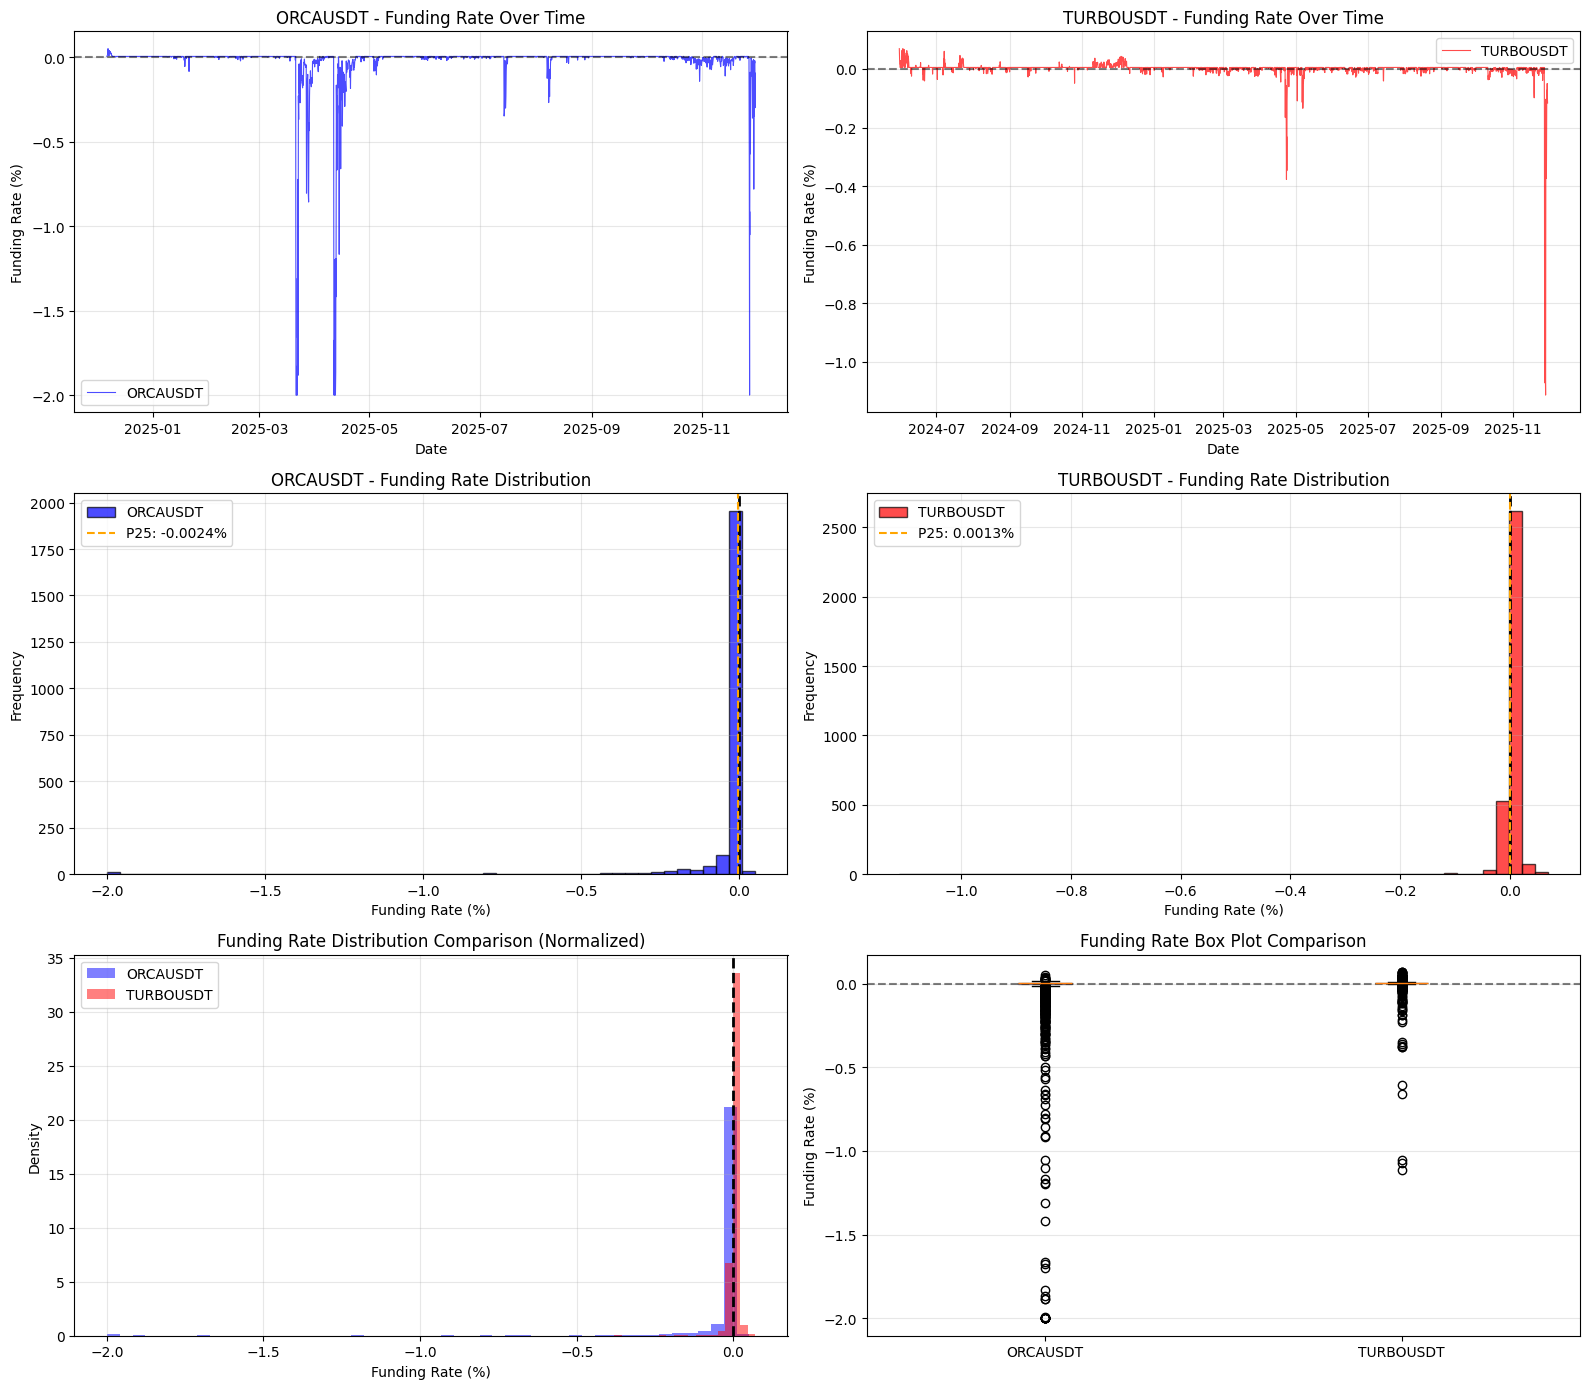

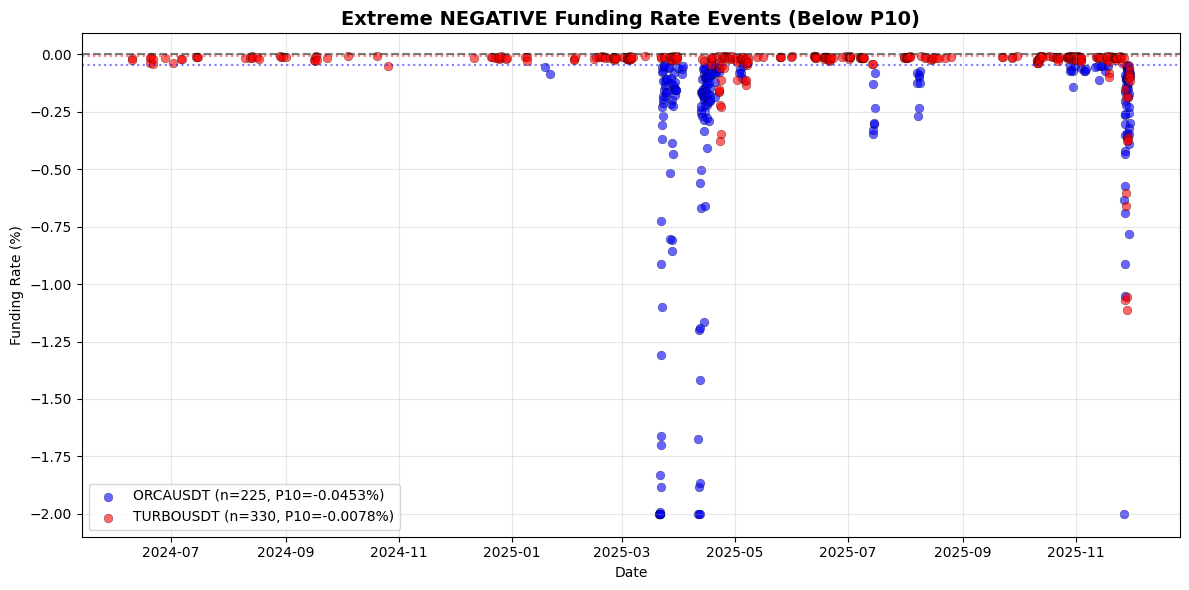

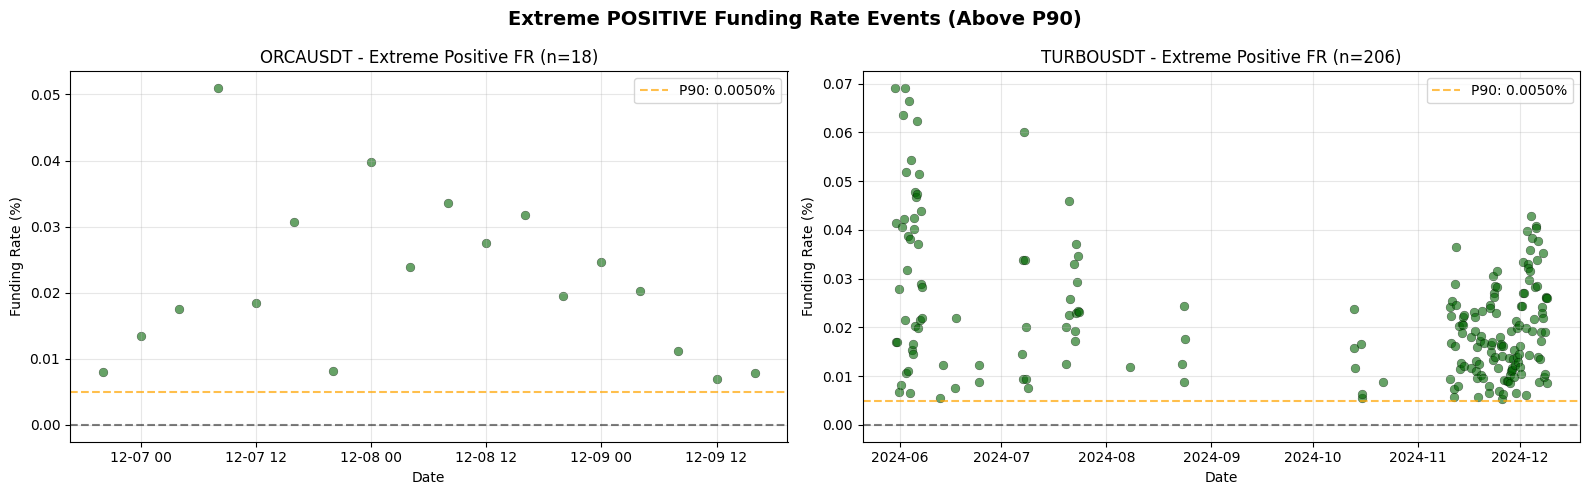

In [14]:
# COMPARE FUNDING RATE SPIKES BETWEEN TWO TICKERS
# ============================================================
# Run this cell to compare FR distribution between two tickers

fr_comparison = compare_funding_rate_spikes('ORCAUSDT', 'TURBOUSDT')




In [15]:
# BASIS VS FUNDING RATE CORRELATION CHART
# ============================================================
# Run this cell to plot the basis vs funding rate scatter plot
fr_correlation = False
if fr_correlation:
    SYMBOL_BASIS = 'ORCAUSDT'
    TIMEFRAME_BASIS = '5m'

    # Load and merge data
    df_futures_basis = load_futures_data(SYMBOL_BASIS, TIMEFRAME_BASIS)
    df_spot_basis = load_spot_data(SYMBOL_BASIS, TIMEFRAME_BASIS)
    df_funding_basis = load_funding_rate(SYMBOL_BASIS)
    df_merged_basis = merge_all_data(df_futures_basis, df_spot_basis, df_funding_basis)
    df_merged_basis = calculate_features(df_merged_basis)

    # Plot basis vs funding rate
    plot_basis_vs_funding_rate(df_merged_basis, SYMBOL_BASIS)

In [16]:
# TARGET VARIABLE DEFINITION CHART
# ============================================================
# Run this cell to plot the funding rate distribution with threshold

required_plot_target_variable_distribution = False
if required_plot_target_variable_distribution:
    SYMBOL_TARGET = 'RESOLVUSDT'
    FR_PERCENTILE_TARGET = 0.20  # 25th percentile threshold

    plot_target_variable_distribution(SYMBOL_TARGET, fr_percentile=FR_PERCENTILE_TARGET)
else:
    pass

In [17]:
# MARKET CAP FILTERING VISUALIZATION
# ============================================================

def plot_market_cap_filter(symbols_all, symbols_selected, mcap_threshold=100, save_path=None):
    """Plot market cap filtering criteria showing which coins were kept vs filtered.

    Args:
        symbols_all: List of all candidate symbols
        symbols_selected: List of symbols that passed the filter (mcap < threshold)
        mcap_threshold: Market cap threshold in millions (default 100M)
        save_path: Optional path to save the figure
    """
    # Identify filtered vs kept
    symbols_filtered = [s for s in symbols_all if s not in symbols_selected]

    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8))

    # Prepare data for horizontal bar chart
    all_symbols = symbols_filtered + symbols_selected
    n_filtered = len(symbols_filtered)
    n_kept = len(symbols_selected)

    # Create bars
    y_pos = np.arange(len(all_symbols))
    colors = ['#d62728'] * n_filtered + ['#2ca02c'] * n_kept  # Red for filtered, green for kept

    # Create placeholder values (visual representation)
    # Filtered coins shown as > threshold, kept coins shown as < threshold
    bar_values = [mcap_threshold * 1.5] * n_filtered + [mcap_threshold * 0.5] * n_kept

    bars = ax.barh(y_pos, bar_values, color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)

    # Add threshold line
    ax.axvline(x=mcap_threshold, color='#333333', linestyle='--', linewidth=2.5,
               label=f'Threshold: ${mcap_threshold}M Market Cap')

    # Labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels([s.replace('USDT', '') for s in all_symbols], fontsize=10)
    ax.set_xlabel('Market Cap Filter Criteria', fontsize=12, fontweight='bold')
    ax.set_title(f'Coin Selection: Market Cap < ${mcap_threshold}M Filter\n'
                 f'Filtered Out: {n_filtered} coins | Selected: {n_kept} coins',
                 fontsize=14, fontweight='bold', pad=15)

    # Add category labels
    ax.text(mcap_threshold * 1.7, n_filtered / 2, f'FILTERED OUT\n(MCap > ${mcap_threshold}M)\n{n_filtered} coins',
            ha='center', va='center', fontsize=11, fontweight='bold', color='#d62728',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='#d62728', alpha=0.9))

    ax.text(mcap_threshold * 0.3, n_filtered + n_kept / 2, f'SELECTED\n(MCap < ${mcap_threshold}M)\n{n_kept} coins',
            ha='center', va='center', fontsize=11, fontweight='bold', color='#2ca02c',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='#2ca02c', alpha=0.9))

    # Add horizontal line separating filtered and kept
    if n_filtered > 0 and n_kept > 0:
        ax.axhline(y=n_filtered - 0.5, color='gray', linestyle='-', linewidth=1, alpha=0.5)

    # Styling
    ax.set_xlim(0, mcap_threshold * 2)
    ax.set_xticklabels([])  # Hide x-axis values since they're illustrative
    ax.grid(True, alpha=0.3, axis='x', linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.legend(loc='upper right', fontsize=10)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to {save_path}")

    plt.show()

    # Print summary
    print(f"\n--- Market Cap Filter Summary ---")
    print(f"Threshold: < ${mcap_threshold}M")
    print(f"Total candidates: {len(symbols_all)}")
    print(f"Filtered out (MCap > ${mcap_threshold}M): {n_filtered}")
    for s in symbols_filtered:
        print(f"  - {s.replace('USDT', '')}")
    print(f"Selected (MCap < ${mcap_threshold}M): {n_kept}")
    for s in symbols_selected:
        print(f"  + {s.replace('USDT', '')}")

    return fig




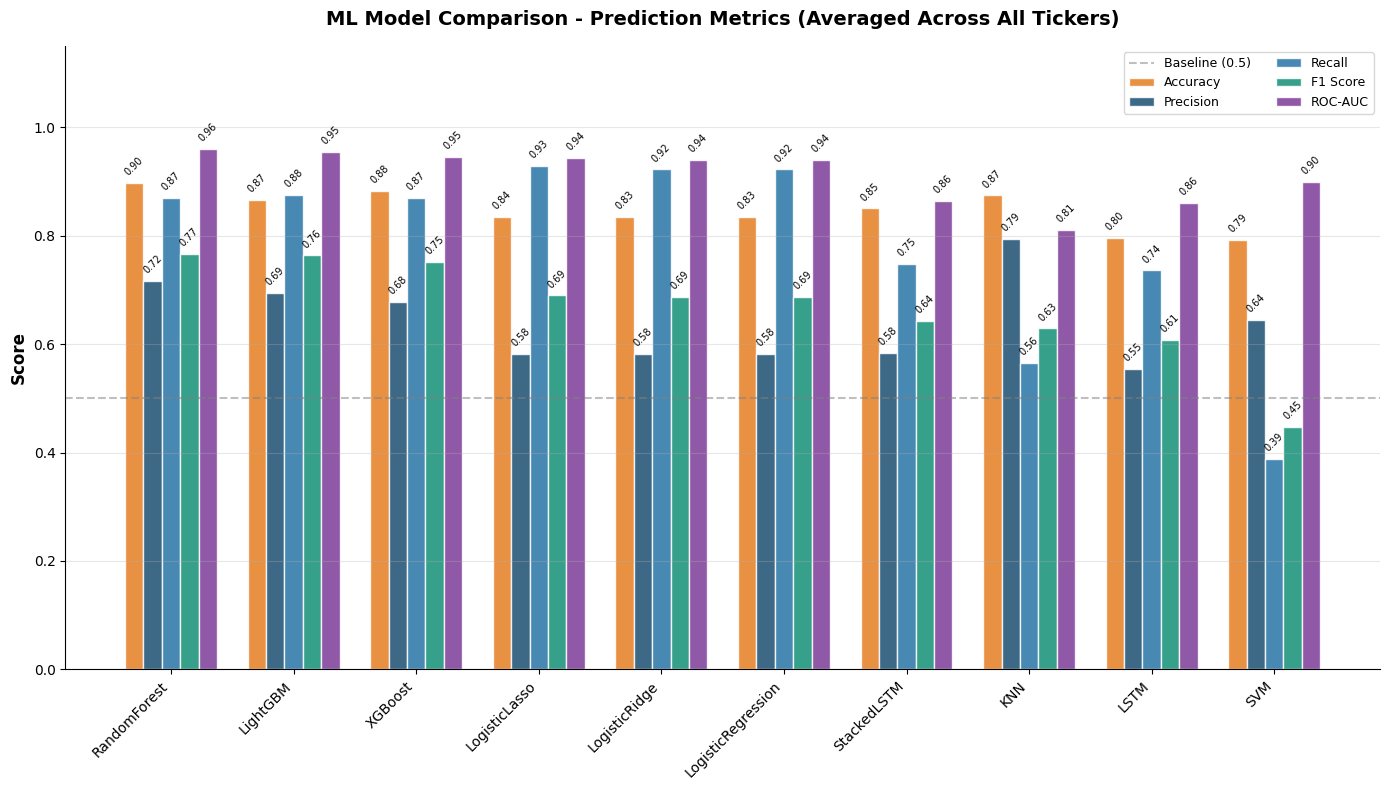


MODEL RANKING BY F1 SCORE
RandomForest         | F1: 0.7657 | ROC-AUC: 0.9599
LightGBM             | F1: 0.7635 | ROC-AUC: 0.9548
XGBoost              | F1: 0.7515 | ROC-AUC: 0.9453
LogisticLasso        | F1: 0.6897 | ROC-AUC: 0.9426
LogisticRidge        | F1: 0.6868 | ROC-AUC: 0.9396
LogisticRegression   | F1: 0.6868 | ROC-AUC: 0.9396
StackedLSTM          | F1: 0.6424 | ROC-AUC: 0.8642
KNN                  | F1: 0.6290 | ROC-AUC: 0.8104
LSTM                 | F1: 0.6080 | ROC-AUC: 0.8599
SVM                  | F1: 0.4466 | ROC-AUC: 0.8993


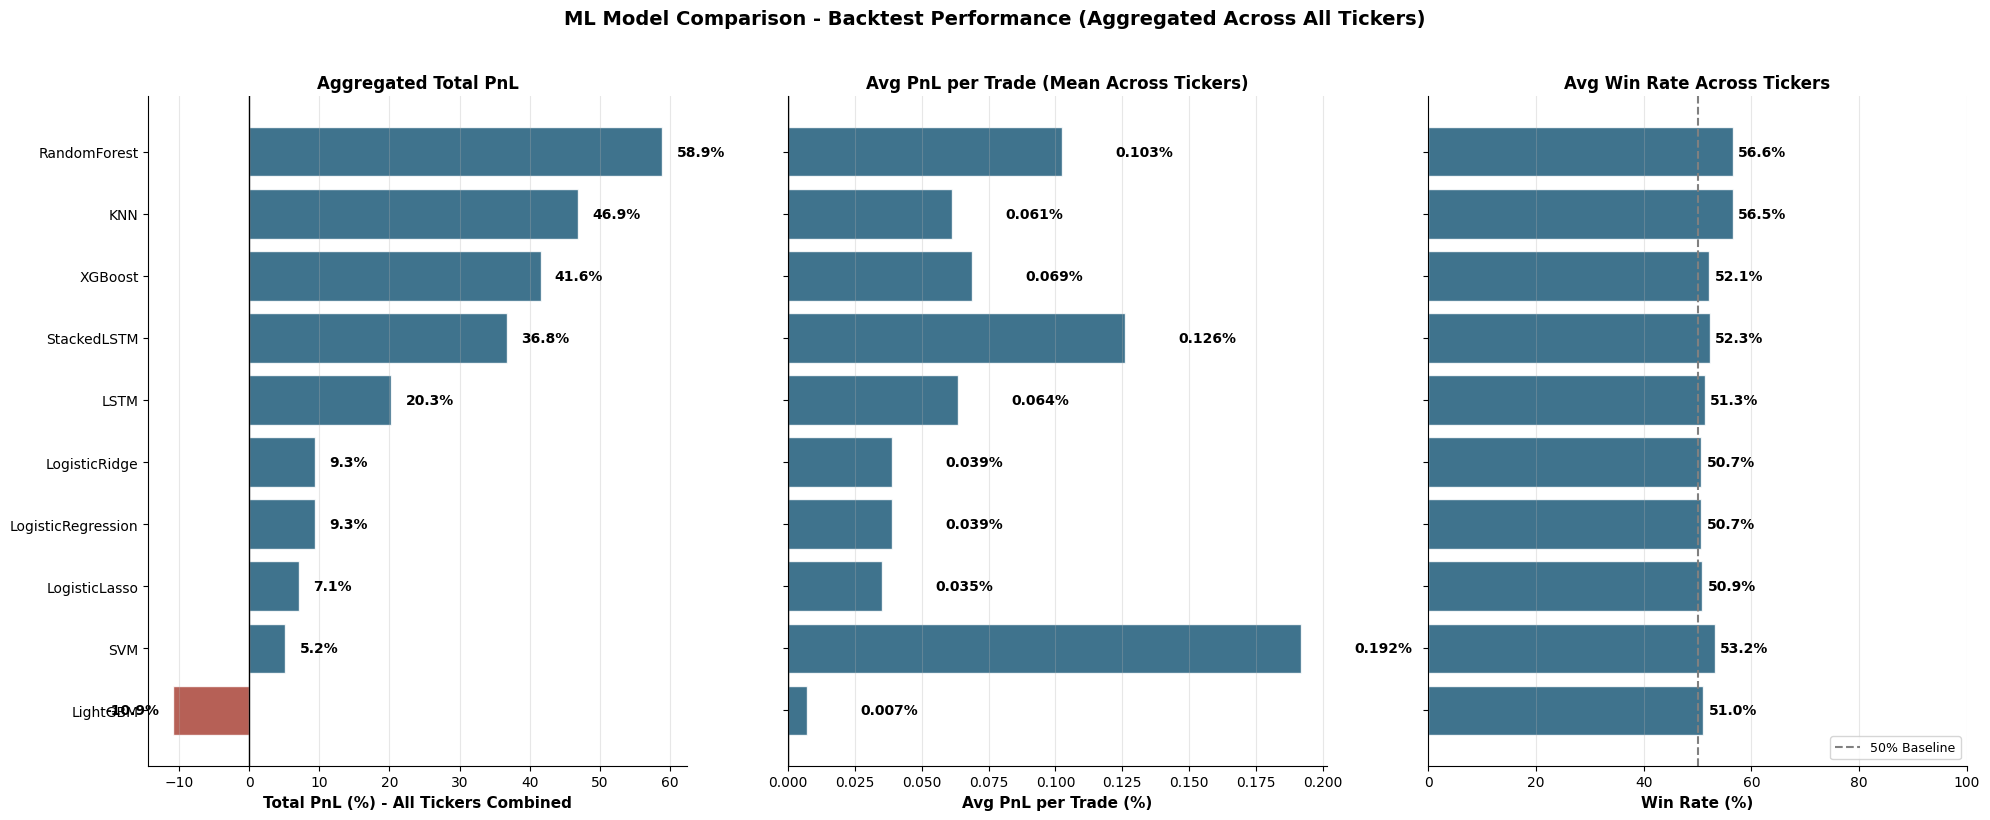


MODEL RANKING BY AGGREGATED TOTAL PnL
RandomForest         | Total PnL:    58.94% | Trades:   480 | Win Rate:  56.6%
KNN                  | Total PnL:    46.92% | Trades:   323 | Win Rate:  56.5%
XGBoost              | Total PnL:    41.58% | Trades:   606 | Win Rate:  52.1%
StackedLSTM          | Total PnL:    36.78% | Trades:   565 | Win Rate:  52.3%
LSTM                 | Total PnL:    20.29% | Trades:   705 | Win Rate:  51.3%
LogisticRegression   | Total PnL:     9.34% | Trades:   862 | Win Rate:  50.7%
LogisticRidge        | Total PnL:     9.34% | Trades:   862 | Win Rate:  50.7%
LogisticLasso        | Total PnL:     7.11% | Trades:   865 | Win Rate:  50.9%
SVM                  | Total PnL:     5.16% | Trades:   227 | Win Rate:  53.2%
LightGBM             | Total PnL:   -10.90% | Trades:   985 | Win Rate:  51.0%


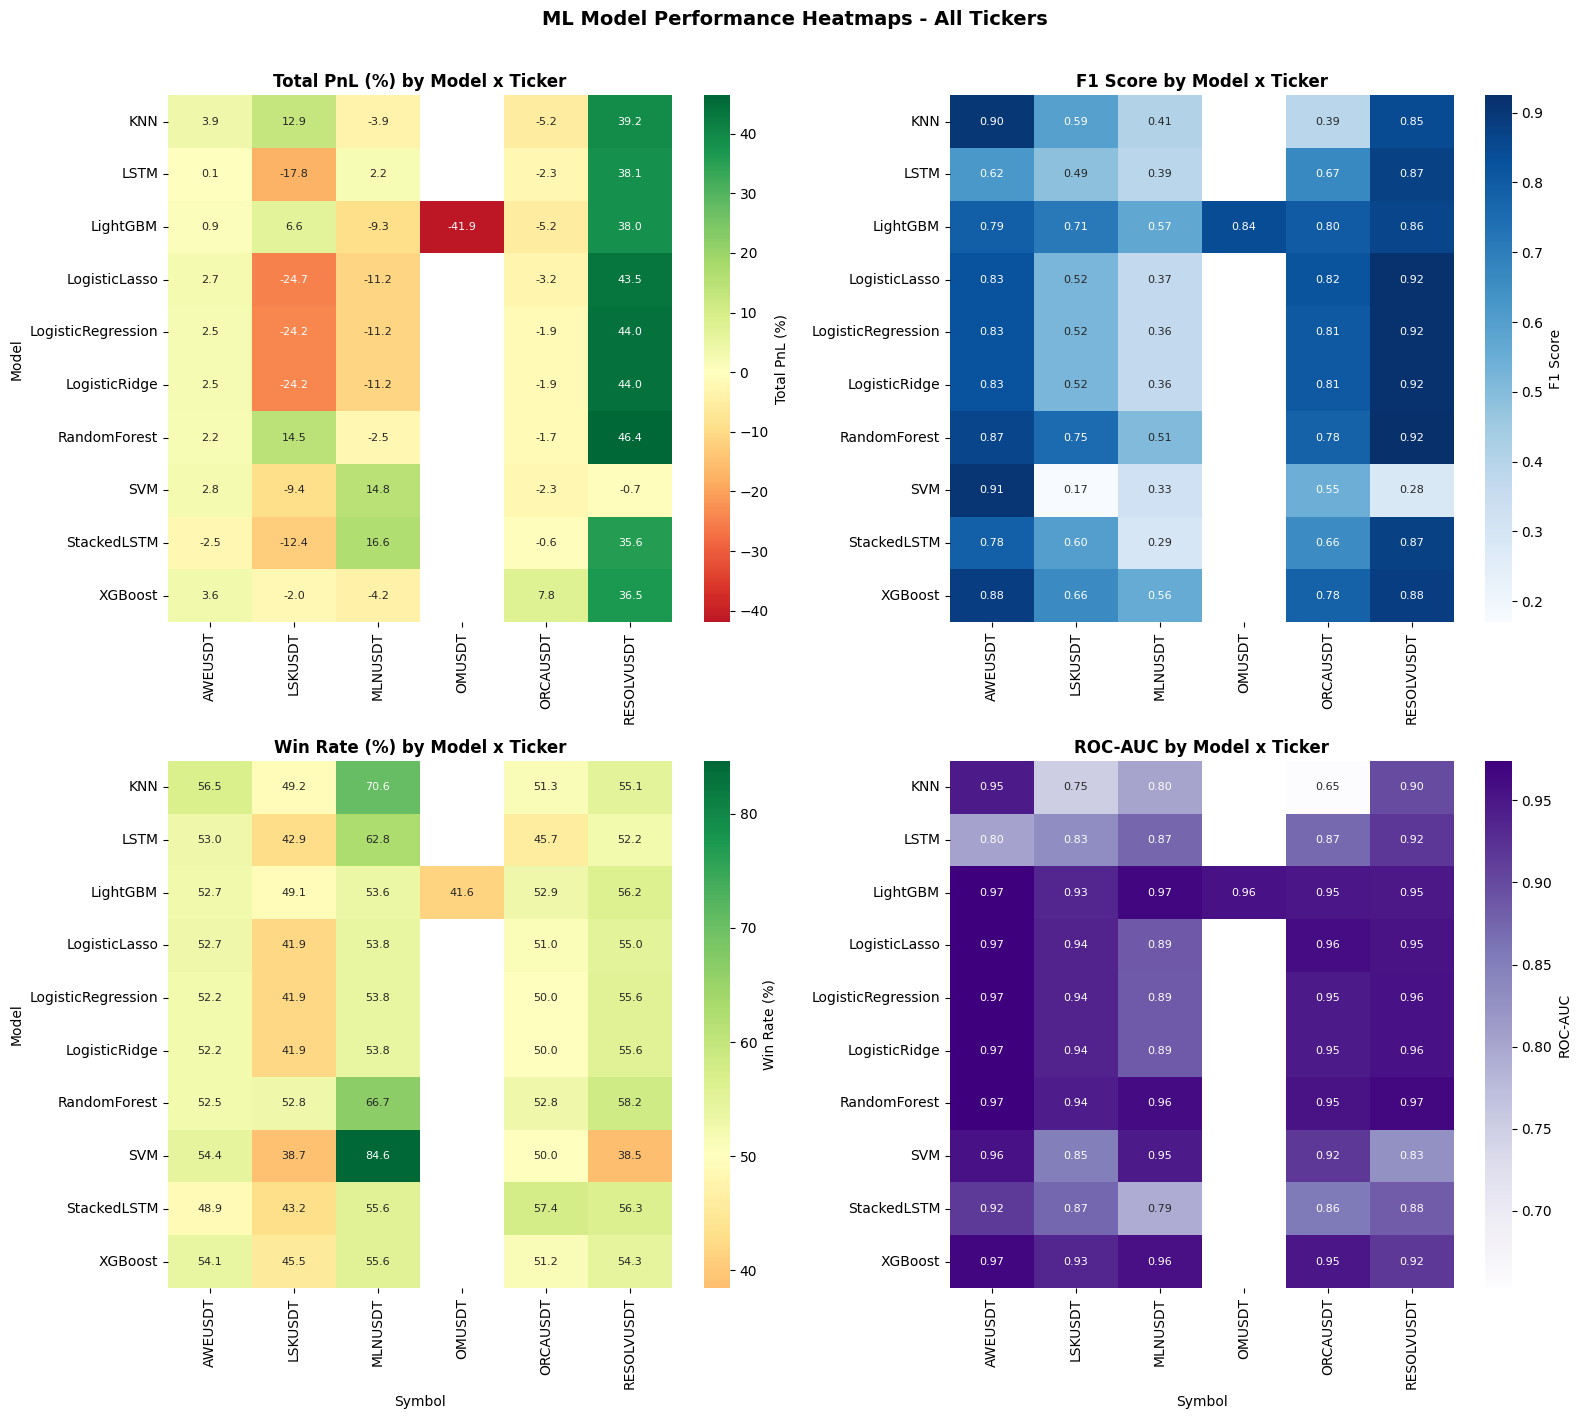


TRADE DATE RANGE SUMMARY
Overall Test Period: 2025-03-02 08:00 to 2025-11-30 09:00
Total Duration: 273 days

First Trade: 2025-03-02 08:00:00
Last Trade:  2025-11-30 09:00:00

DATE RANGE BY MODEL
KNN                  | 2025-03-11 to 2025-11-30 | 323 trades
LSTM                 | 2025-03-09 to 2025-11-30 | 705 trades
LightGBM             | 2025-03-02 to 2025-11-30 | 985 trades
LogisticLasso        | 2025-03-09 to 2025-11-30 | 865 trades
LogisticRegression   | 2025-03-09 to 2025-11-30 | 862 trades
LogisticRidge        | 2025-03-09 to 2025-11-30 | 862 trades
RandomForest         | 2025-03-10 to 2025-11-30 | 480 trades
SVM                  | 2025-03-09 to 2025-11-30 | 227 trades
StackedLSTM          | 2025-03-09 to 2025-11-30 | 565 trades
XGBoost              | 2025-03-09 to 2025-11-30 | 606 trades


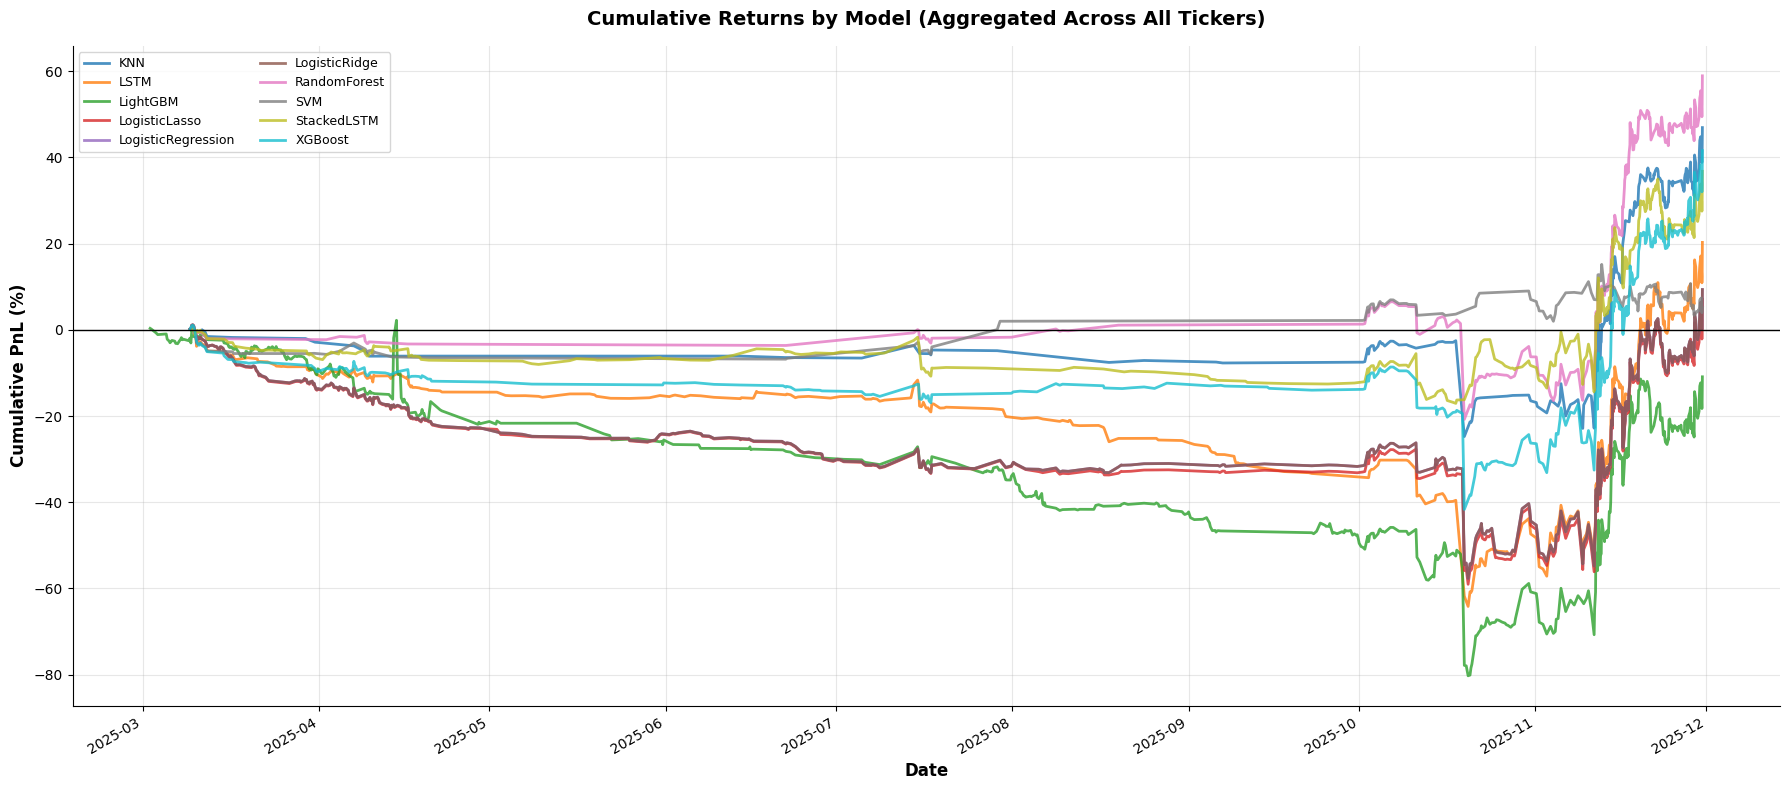

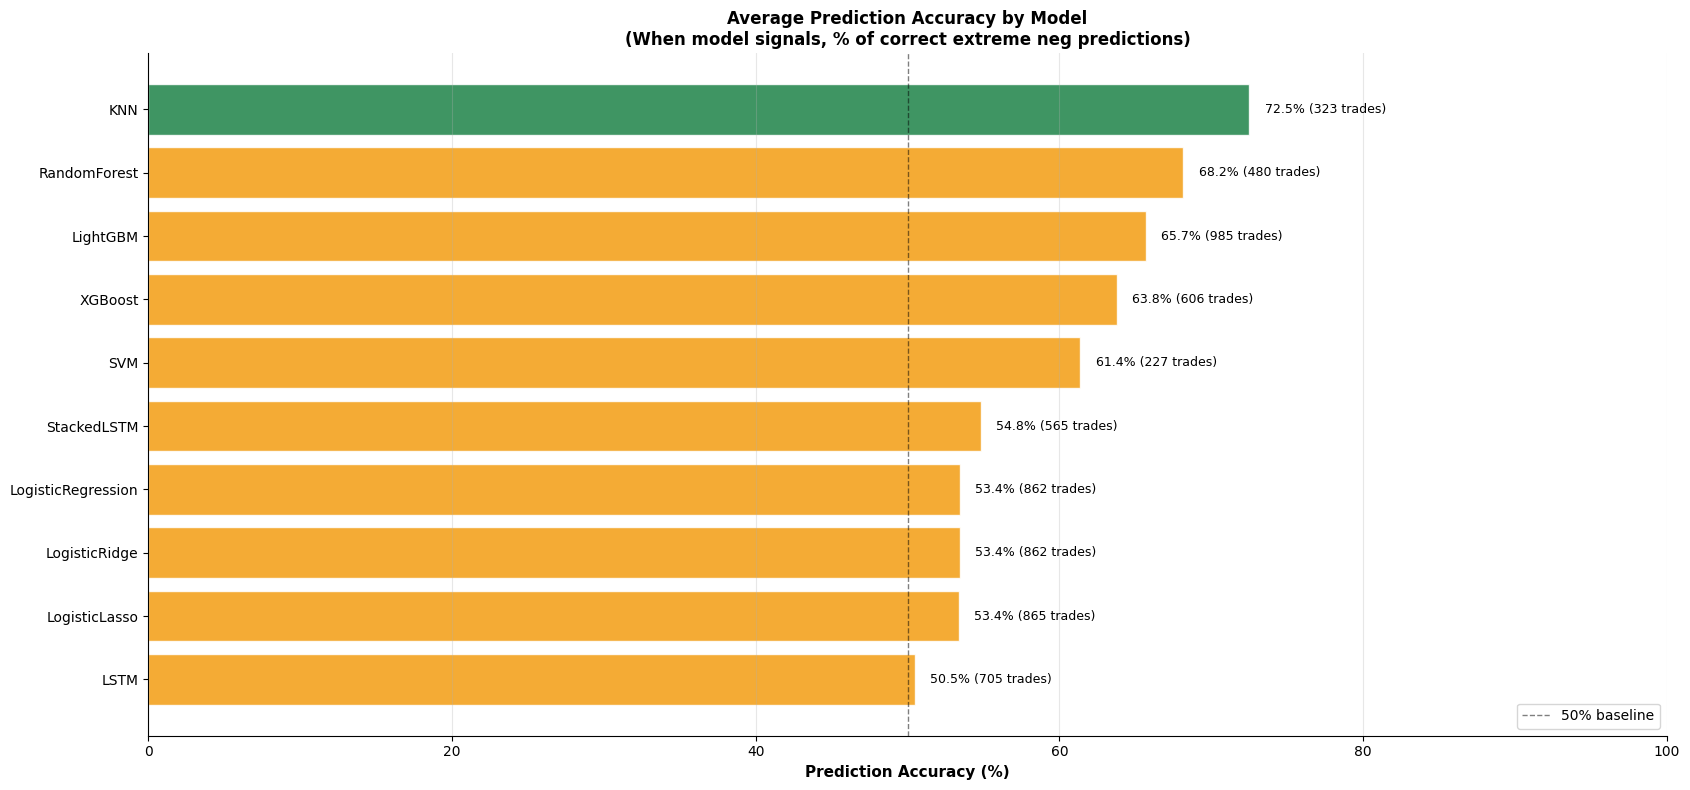


ML MODEL PERFORMANCE SUMMARY

Model                   Total PnL  Avg PnL/Trade   Win Rate   Pred Acc   N Trades
------------------------------------------------------------------------------------------
RandomForest               58.94%        0.1025%      56.6%      68.2%        480
KNN                        46.92%        0.0612%      56.5%      72.5%        323
XGBoost                    41.58%        0.0687%      52.1%      63.8%        606
StackedLSTM                36.78%        0.1262%      52.3%      54.8%        565
LSTM                       20.29%        0.0635%      51.3%      50.5%        705
LogisticRidge               9.34%        0.0386%      50.7%      53.4%        862
LogisticRegression          9.34%        0.0386%      50.7%      53.4%        862
LogisticLasso               7.11%        0.0351%      50.9%      53.4%        865
SVM                         5.16%        0.1920%      53.2%      61.4%        227
LightGBM                  -10.90%        0.0070%      51.0

In [18]:
# COMPARE ALL ML MODELS
# ============================================================
# Run these cells to compare all ML models across all tickers
compare_all_models = True
if compare_all_models:
    # 1. Compare prediction metrics (Accuracy, Precision, Recall, F1, ROC-AUC)
    fig_metrics, df_metrics = compare_all_models_metrics()

    # 2. Compare backtest returns (Aggregated Total PnL, Avg PnL, Win Rate)
    fig_returns, df_returns = compare_all_models_returns()

    # 3. Heatmaps showing performance by Model x Ticker
    fig_heatmap, df_heatmap = compare_all_models_heatmap()

    # 4. Get trade date ranges
    date_ranges = get_trade_date_range()

    # 5. Cumulative returns over time by model
    fig_cumulative, df_cumulative = compare_cumulative_returns()

    # 6. Prediction accuracy comparison
    fig_pred_acc, df_pred_acc = compare_prediction_accuracy()
    df_summary = print_model_summary()

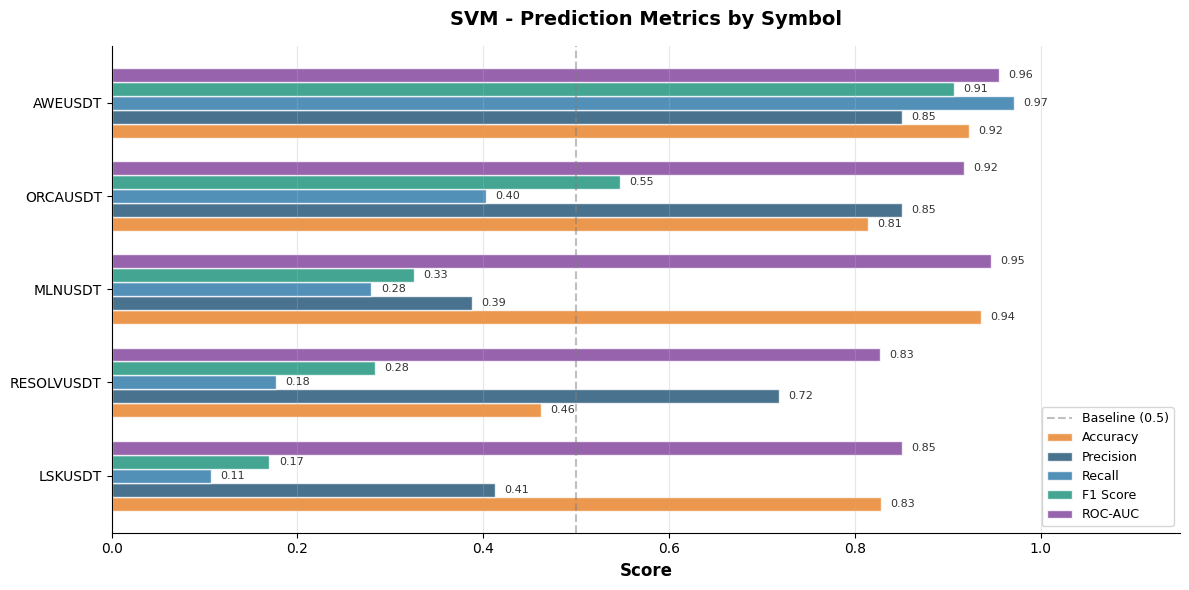

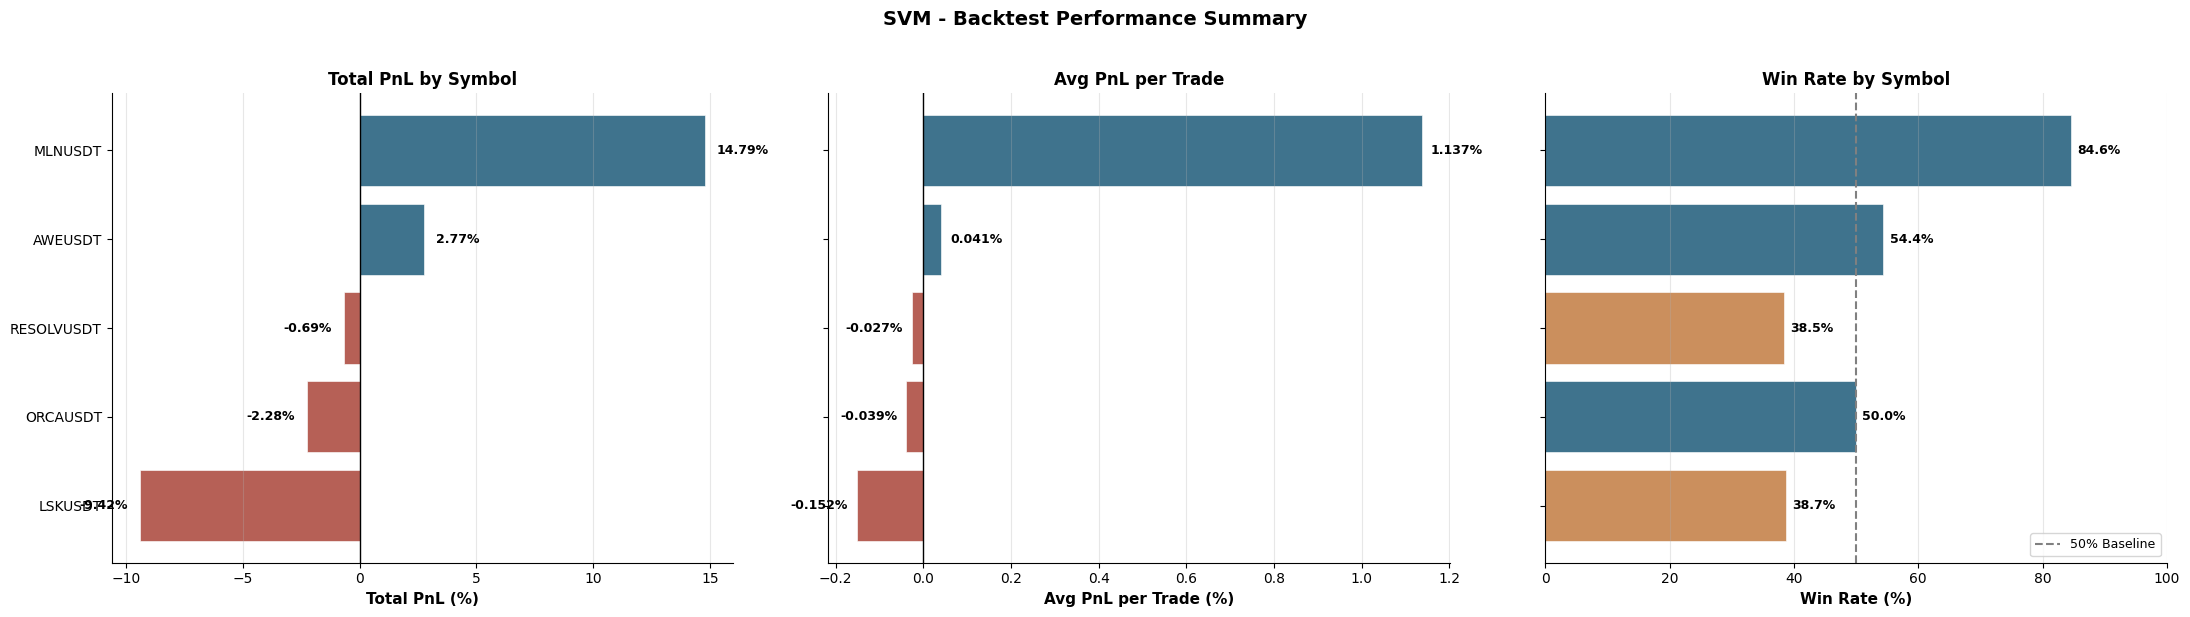


SVM BACKTEST SUMMARY
Total Symbols: 5
Avg Total PnL: 1.0316%
Avg Win Rate: 53.24%
Best Symbol: MLNUSDT (14.79% PnL)
Worst Symbol: LSKUSDT (-9.42% PnL)


(<Figure size 2200x600 with 3 Axes>,
        symbol model feature_selection  n_features  train_samples  \
 1     LSKUSDT   SVM              None          40          26426   
 3    ORCAUSDT   SVM              None          40          11714   
 4  RESOLVUSDT   SVM              None          40           4134   
 0     AWEUSDT   SVM              None          40           4224   
 2     MLNUSDT   SVM              None          40           6029   
 
    test_samples  test_accuracy  test_precision  test_recall   test_f1  \
 1         11326       0.828360        0.412863     0.106989  0.169940   
 3          5021       0.813981        0.850679     0.403145  0.547042   
 4          1773       0.462493        0.718631     0.176966  0.283997   
 0          1811       0.922695        0.850560     0.971550  0.907039   
 2          2584       0.935759        0.388350     0.279720  0.325203   
 
    test_roc_auc  n_trades  total_pnl_pct  avg_pnl_pct  win_rate  \
 1      0.850441        62      -

In [19]:
# ML MODEL PERFORMANCE VISUALIZATION
# ============================================================
# Plot prediction metrics and backtest returns for any ML model
# Just change MODEL_NAME to switch between models (e.g., 'LightGBM', 'XGBoost', 'RandomForest')

MODEL_NAME = 'LightGBM'  # <-- Change this to switch models
MODEL_NAME = 'XGBoost'  # <-- Change this to switch models
MODEL_NAME = 'KNN'  # <-- Change this to switch models
MODEL_NAME = 'RandomForest'  # <-- Change this to switch models
MODEL_NAME = 'SVM'  # <-- Change this to switch models
MODEL_NAME = 'LSTM'  # <-- Change this to switch models
MODEL_NAME = 'StackedLSTM'  # <-- Change this to switch models
MODEL_NAME = 'LogisticRegression'  # <-- Change this to switch models
MODEL_NAME = 'LogisticLasso'  # <-- Change this to switch models
MODEL_NAME = 'LogisticRidge'  # <-- Change this to switch models
MODEL_NAME = 'KNN'  # <-- Change this to switch models
MODEL_NAME = 'SVM'  # <-- Change this to switch models

# Plot 1: Prediction Metrics (Precision, Recall, F1, ROC-AUC)
plot_model_prediction_metrics(model_name=MODEL_NAME)

# Plot 2: Backtest Returns (Total PnL, Avg PnL, Win Rate)
plot_model_backtest_returns(model_name=MODEL_NAME)



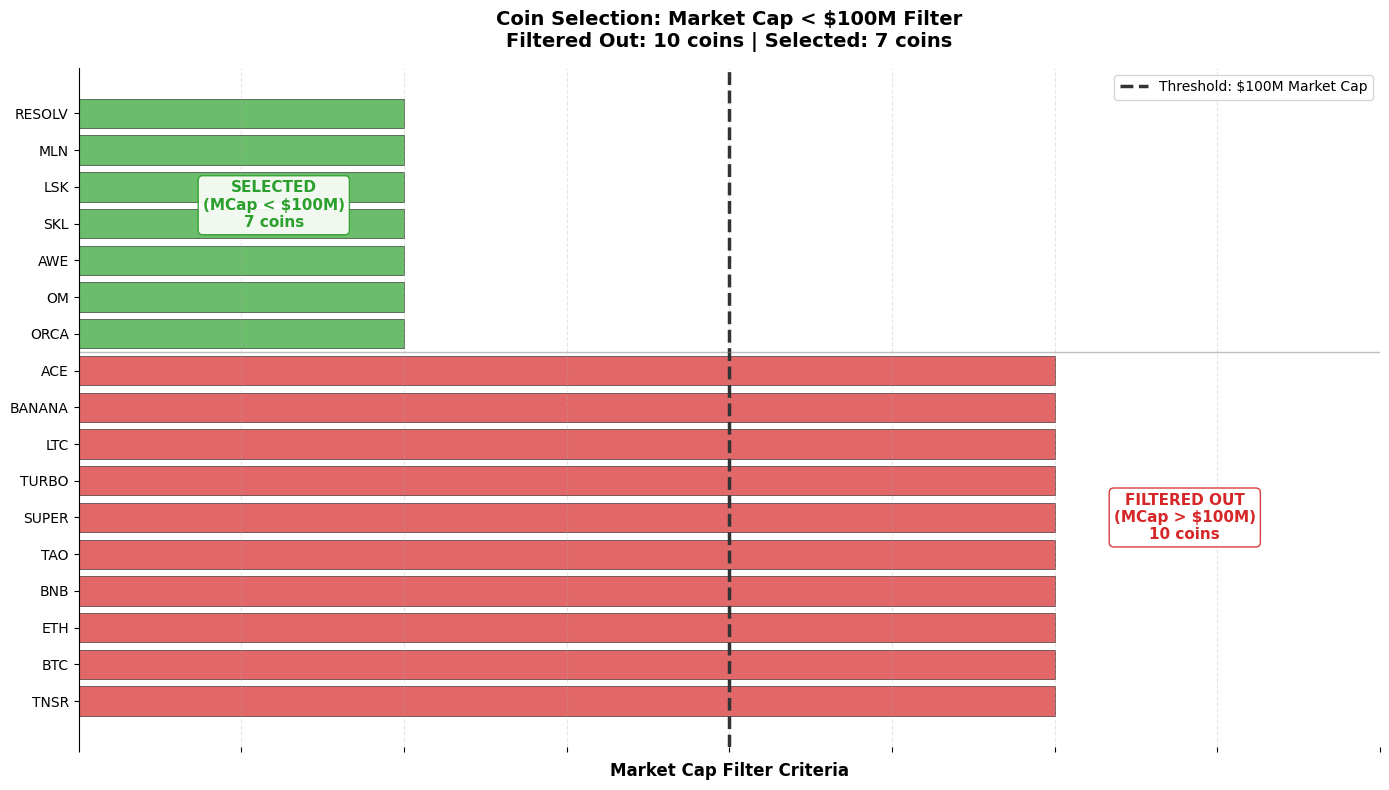


--- Market Cap Filter Summary ---
Threshold: < $100M
Total candidates: 16
Filtered out (MCap > $100M): 10
  - TNSR
  - BTC
  - ETH
  - BNB
  - TAO
  - SUPER
  - TURBO
  - LTC
  - BANANA
  - ACE
Selected (MCap < $100M): 7
  + ORCA
  + OM
  + AWE
  + SKL
  + LSK
  + MLN
  + RESOLV

FUNDING RATE DISTRIBUTION ANALYSIS - FULL DATA

Symbol        Total   Neg   Pos    %Neg    Mean%     P25%  P25<0?
----------------------------------------------------------------------
RESOLVUSDT     1105   437   668   39.5% -0.0558% -0.0284%    Yes
OMUSDT         3936  1483  2453   37.7% -0.0153% -0.0107%    Yes
AWEUSDT        1159   378   781   32.6% -0.0337% -0.0094%    Yes
SUPERUSDT      5139  1511  3628   29.4% -0.0057% -0.0026%    Yes
ORCAUSDT       2251   616  1635   27.4% -0.0361% -0.0024%    Yes
BNBUSDT        6360  1731  4629   27.2% -0.0004% -0.0026%    Yes
LSKUSDT        4392  1129  3263   25.7% -0.0096% -0.0006%    Yes
BANANAUSDT     2836   667  2169   23.5% -0.0043%  0.0011%     No <-- SKIP
TURB

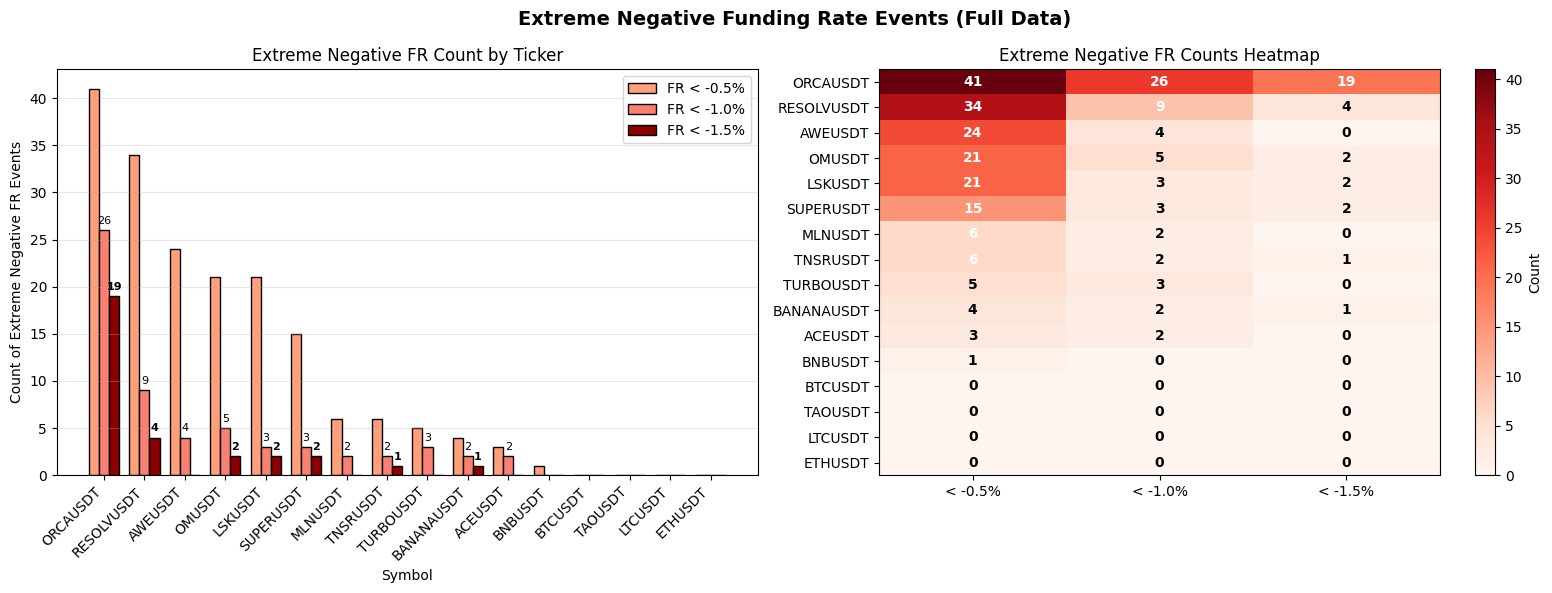


FUNDING RATE DISTRIBUTION ANALYSIS - TRAINING DATA (70%)

Symbol        Total   Neg   Pos    %Neg    Mean%     P25%  P25<0?
----------------------------------------------------------------------
OMUSDT         2755   864  1891   31.4% -0.0048% -0.0044%    Yes
BNBUSDT        4452  1386  3066   31.1% -0.0002% -0.0077%    Yes
AWEUSDT         811   211   600   26.0% -0.0190% -0.0008%    Yes
BANANAUSDT     1985   476  1509   24.0% -0.0038%  0.0009%     No <-- SKIP
RESOLVUSDT      773   184   589   23.8% -0.0087%  0.0013%     No <-- SKIP
ORCAUSDT       1575   355  1220   22.5% -0.0410%  0.0020%     No <-- SKIP
LSKUSDT        3074   593  2481   19.3% -0.0001%  0.0050%     No <-- SKIP
TURBOUSDT      2305   353  1952   15.3%  0.0031%  0.0044%     No <-- SKIP
TNSRUSDT       2657   382  2275   14.4%  0.0034%  0.0050%     No <-- SKIP
TAOUSDT        2509   349  2160   13.9%  0.0032%  0.0050%     No <-- SKIP
SUPERUSDT      3597   482  3115   13.4%  0.0035%  0.0050%     No <-- SKIP
BTCUSDT        45

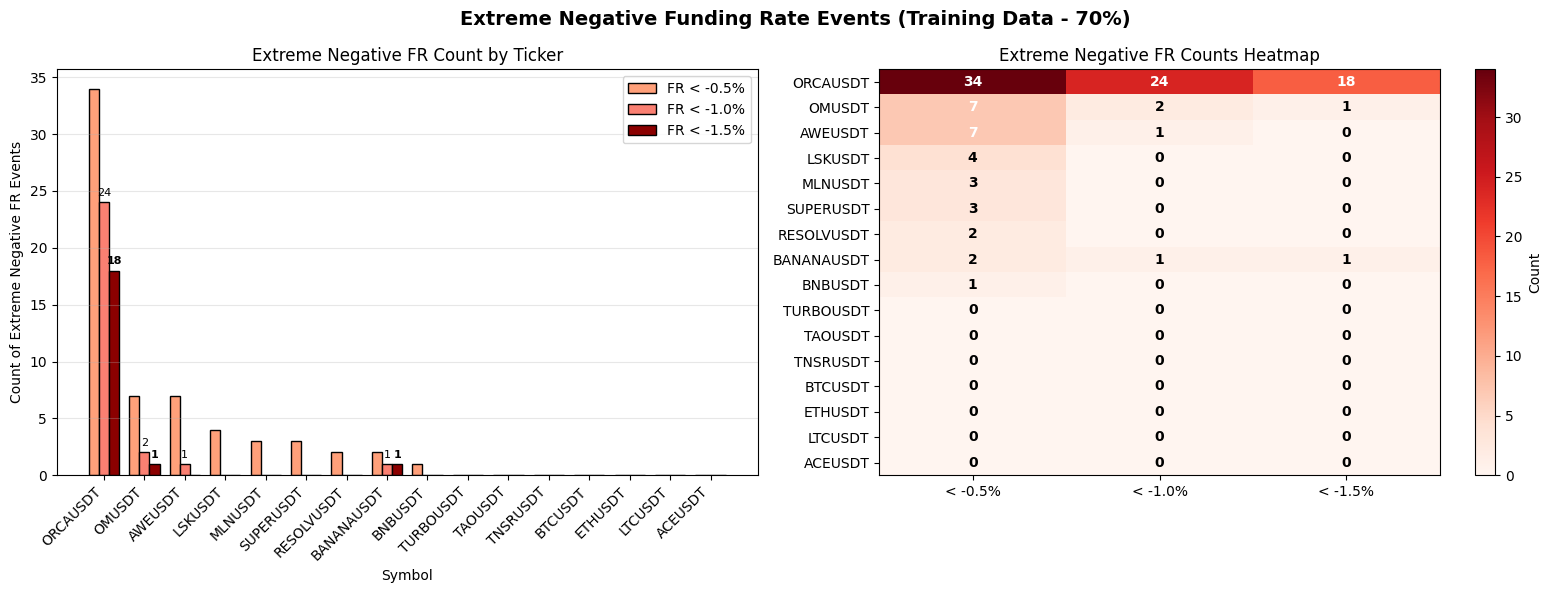

In [20]:
# FUNDING RATE DISTRIBUTION ANALYSIS
# ============================================================
# Run this cell to analyze which tickers are suitable for ML training
# based on their funding rate distribution

# 'ORCAUSDT', "OMUSDT", "AWEUSDT", "SKLUSDT", "LSKUSDT", "MLNUSDT", "RESOLVUSDT"
SYMBOLS_FR_1 = [
     'ORCAUSDT', "OMUSDT", "AWEUSDT", "SKLUSDT", "LSKUSDT", "MLNUSDT", "RESOLVUSDT"
]
SYMBOLS_FR_2 = ["TNSRUSDT", "BTCUSDT", "ETHUSDT", "BNBUSDT", "TAOUSDT", "SUPERUSDT", "LSKUSDT", "RESOLVUSDT", "ORCAUSDT", "TURBOUSDT", "LTCUSDT", "BANANAUSDT", "ACEUSDT", "AWEUSDT", "MLNUSDT", "OMUSDT"]

# Plot market cap filter
plot_market_cap_filter(SYMBOLS_FR_2, SYMBOLS_FR_1, mcap_threshold=100)


# Full data analysis
df_fr_summary_full = analyze_all_tickers_fr_distribution(SYMBOLS_FR_2, data_split='all')
plot_fr_distribution_comparison(df_fr_summary_full, show_plots=True, title_suffix='(Full Data)')

# Training data analysis (first 70%)
df_fr_summary_train = analyze_all_tickers_fr_distribution(SYMBOLS_FR_2, data_split='train', train_pct=0.7)
plot_fr_distribution_comparison(df_fr_summary_train, show_plots=True, title_suffix='(Training Data - 70%)')


PRICE PATH ANALYSIS: ORCAUSDT
LOADING FUTURES (PERPS) DATA
Loaded 103355 rows of ORCAUSDT FUTURES data
Date range: 2024-12-06 15:00:00 to 2025-11-30 11:50:00

LOADING SPOT DATA
Loaded 103453 rows of ORCAUSDT SPOT data
Date range: 2024-12-06 13:00:00 to 2025-11-30 18:00:00

LOADING FUNDING RATE DATA
Loaded 2251 rows of ORCAUSDT FUNDING RATE data
Date range: 2024-12-06 16:00:00 to 2025-11-30 09:00:00

MERGING ALL DATA
After Futures + Spot merge: 103355 rows
After adding Funding Rate: 103355 rows
Rows with funding rate: 1304

AVERAGE PRICE PATH ANALYSIS
Data split: 70% train / 30% test
  Train period: 2024-12-06 16:00:00 to 2025-07-14 00:00:00
  Test period:  2025-07-14 00:00:00 to 2025-11-30 09:00:00

FR Percentile: 25th (calculated separately for +/- FR)
  Negative FR count: 352
  Positive FR count: 952
  Extreme Negative threshold: <= -0.1153% (most negative 25%)
  Extreme Positive threshold: > 0.0050% (most positive 25%)

Total funding events: 1304
  Extreme Negative (most negative 2

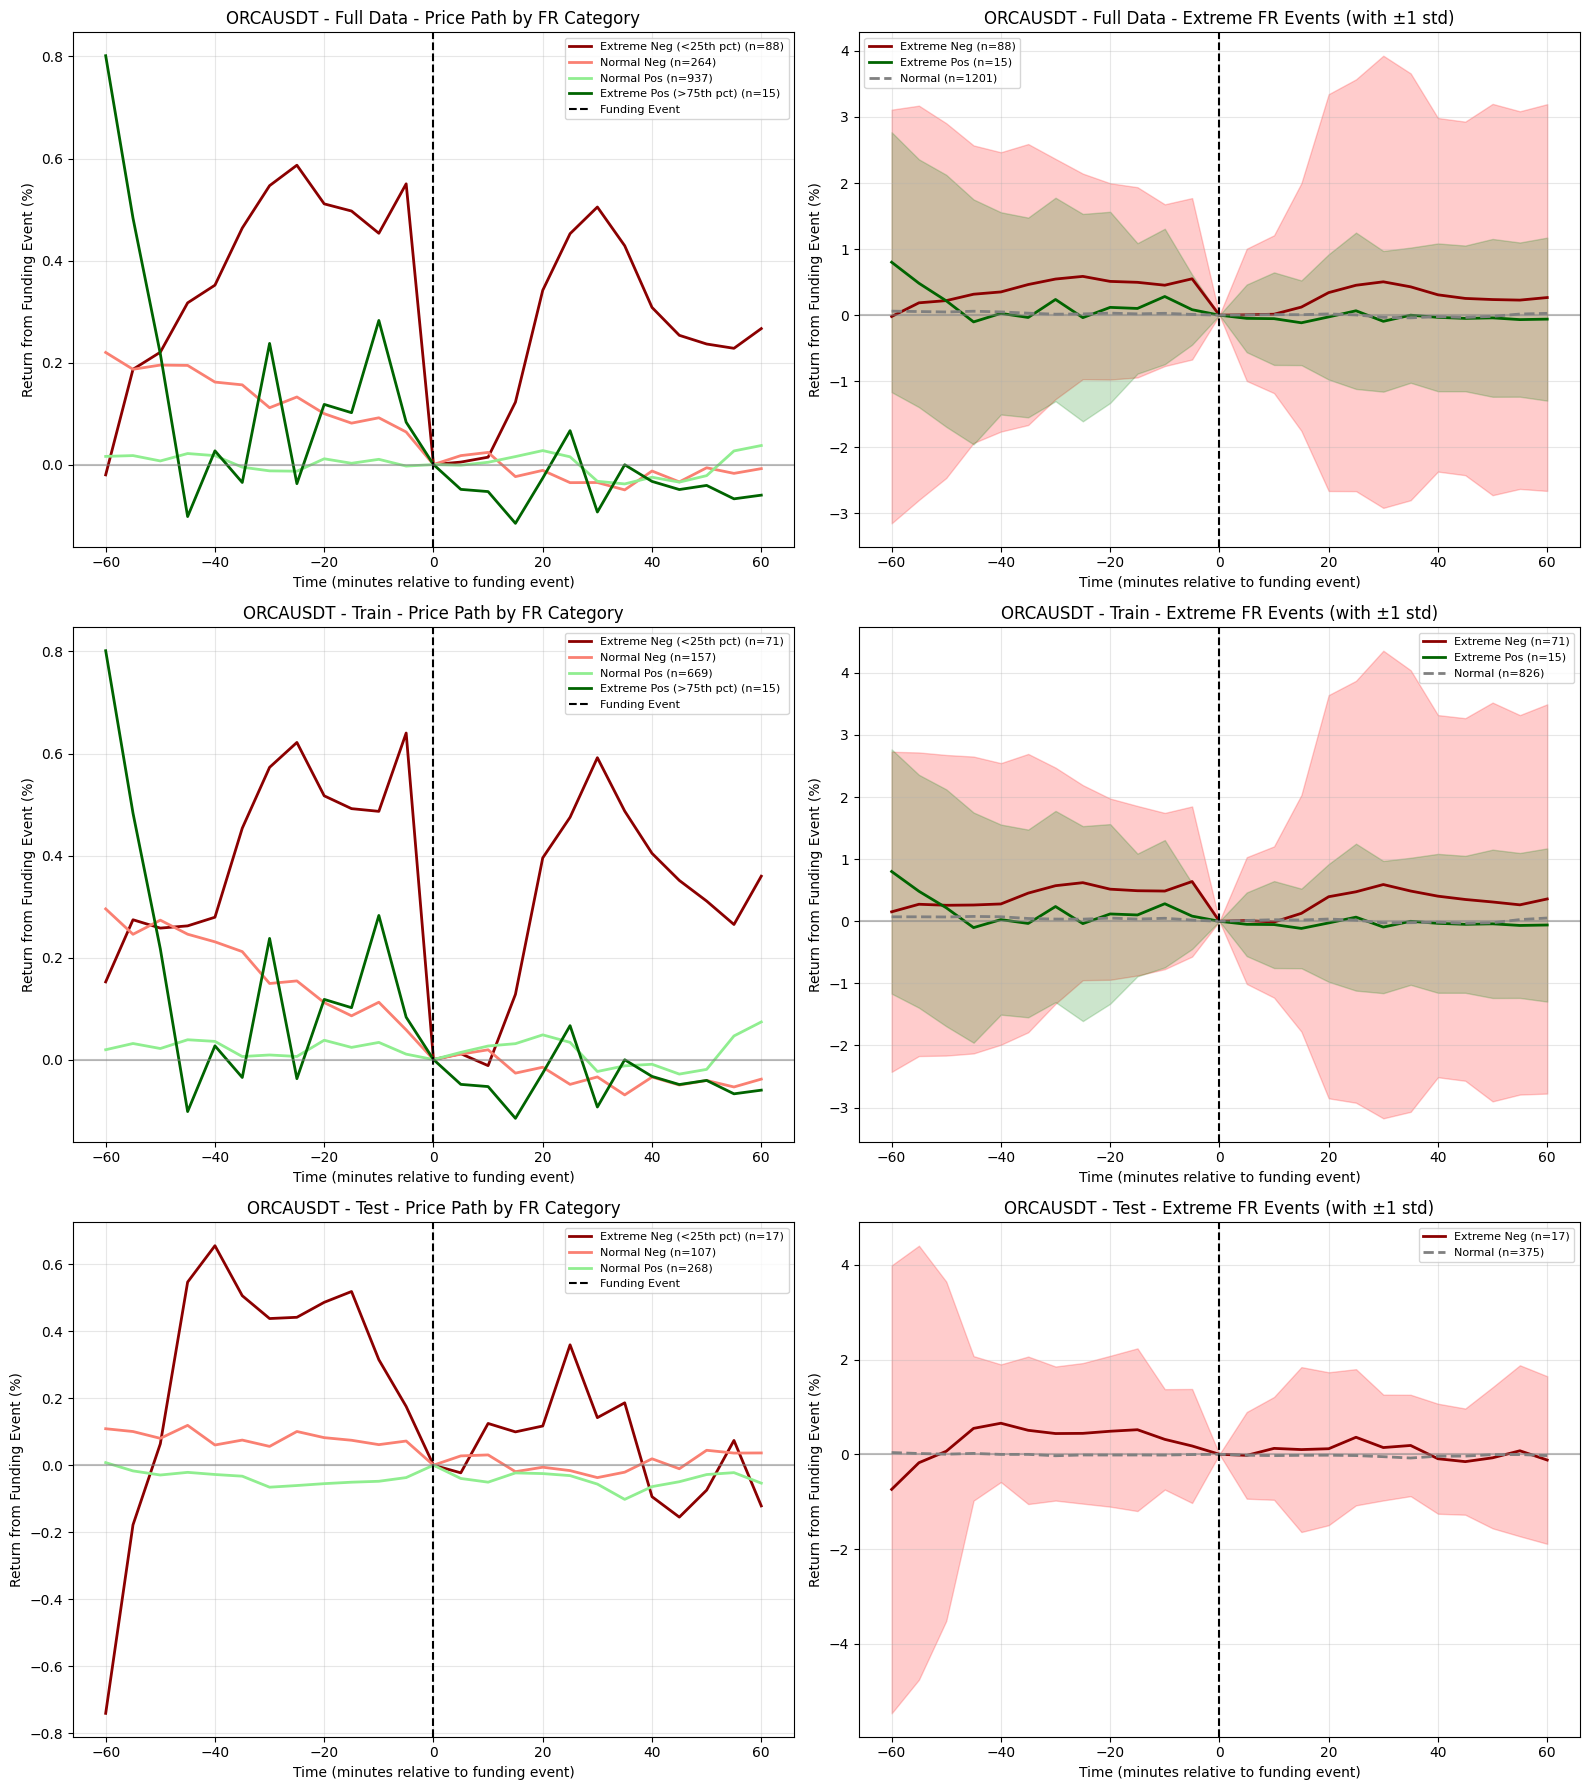


COMPLETED: 1/1 symbols


In [21]:
# PRICE PATH ANALYSIS (STANDALONE)
# ============================================================
# Run this cell to analyze average price path around funding events
# for any ticker without running the full ML pipeline

SYMBOLS_PATH = [
    'TAOUSDT', 'SUPERUSDT',
    'LSKUSDT', 'RESOLVUSDT', 'ORCAUSDT', 'TURBOUSDT',
    'BANANAUSDT', 'SKLUSDT', 'ACEUSDT', 'AWEUSDT', 'MLNUSDT',
    'OMUSDT', 'TNSRUSDT'
]

SYMBOLS_PATH = [
     'RESOLVUSDT', 'ORCAUSDT'
     'MLNUSDT',
     'TNSRUSDT', 'SKLUSDT', 'LSKUSDT', "AWEUSDT"
]

SYMBOLS_PATH = ['ORCAUSDT']

# SYMBOLS_PATH = [
#      'SUPERUSDT',
#     'LSKUSDT', 'RESOLVUSDT', 'ORCAUSDT',
#      'SKLUSDT', 'ACEUSDT', 'AWEUSDT', 'MLNUSDT',
#       'TNSRUSDT'
# ]
TIMEFRAME_PATH = '5m'
WINDOW_BARS = 12
FR_PERCENTILE_PATH = 0.25
TEST_SIZE_PATH = 0.3

all_price_path_results = {}

for symbol in SYMBOLS_PATH:
    print(f"\n{'='*80}")
    print(f"PRICE PATH ANALYSIS: {symbol}")
    print(f"{'='*80}")

    try:
        # Load and merge data
        df_futures = load_futures_data(symbol, TIMEFRAME_PATH)
        df_spot = load_spot_data(symbol, TIMEFRAME_PATH)
        df_funding = load_funding_rate(symbol)
        df_merged = merge_all_data(df_futures, df_spot, df_funding)

        # Run price path analysis
        result = analyze_price_path(
            df_merged, symbol,
            window_bars=WINDOW_BARS,
            fr_percentile=FR_PERCENTILE_PATH,
            test_size=TEST_SIZE_PATH,
            show_plots=True
        )
        all_price_path_results[symbol] = result

    except Exception as e:
        print(f"ERROR processing {symbol}: {e}")
        all_price_path_results[symbol] = {'error': str(e)}

print(f"\n{'='*80}")
print(f"COMPLETED: {len([k for k,v in all_price_path_results.items() if 'error' not in v])}/{len(SYMBOLS_PATH)} symbols")
print(f"{'='*80}")